In [6]:
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
#user param
seqFileName = 'D:/RahLab/deepBreaks/lite_mar/msa_RodOpsinLambdaMax.fasta'
metaDataFileName = 'D:/RahLab/deepBreaks/lite_mar/meta_RodOpsinLambdaMax.tsv'
mt = 'LambdaMax'
seq_type = 'amino-acid'
anaType = 'reg'
sampleFrac=1

In [7]:
# making directory
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [9]:
print('reading meta-data')
# metaData = pd.read_csv(args.metadata, sep='\t', index_col=0)
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

#importing seq data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (175, 2)
reading fasta file
Done
Shape of data is:  (175, 356)


In [10]:
#taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
### add these steps to the powerpoint slide preproccess!
df_cleaned = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df_cleaned.shape)

Shape of data before missing/constant care:  (175, 356)
Shape of data after missing/constant care:  (175, 182)


In [12]:
print('Shape of data before imbalanced care: ', df_cleaned.shape)
df_cleaned = prp.imb_care(dat=df_cleaned, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df_cleaned.shape)

Shape of data before imbalanced care:  (175, 182)
Shape of data after imbalanced care:  (175, 124)


In [13]:
print('number of columns of main data befor: ', df_cleaned.shape[1])
df_cleaned = prp.col_sampler(dat=df_cleaned, sample_frac=sampleFrac)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  124
number of columns of main data after:  124


In [14]:
print('calculating normalized mutual information')
cr = prp.vec_nmi(dat=df_cleaned)
print(cr.shape)

calculating normalized mutual information
(124, 124)


In [15]:
cr.head()

,p32,p33,p35,p36,p37,p38,p39,p41,p46,p49,...,p297,p298,p299,p300,p304,p307,p308,p309,p315,p318
p32,1.000000,0.377131,0.455817,0.331186,0.111894,0.663373,0.108909,0.478883,0.069868,0.212641,...,0.134022,0.056922,0.115904,0.082178,0.111341,0.035567,0.278606,0.000381,0.154572,0.198959
p33,0.377131,1.000000,0.603836,0.331273,0.054757,0.379512,0.278046,0.328180,0.095410,0.269798,...,0.203600,0.101618,0.116714,0.133869,0.282246,0.042488,0.281842,0.116710,0.228806,0.234301
p35,0.455817,0.603836,1.000000,0.364236,0.076950,0.586814,0.186671,0.487918,0.088667,0.253091,...,0.253811,0.085082,0.127266,0.215425,0.203442,0.028359,0.293761,0.011008,0.182868,0.208414
p36,0.331186,0.331273,0.364236,1.000000,0.171480,0.324554,0.352181,0.290161,0.351843,0.438002,...,0.283260,0.075339,0.062956,0.231534,0.249277,0.030552,0.760121,0.044564,0.485919,0.547528
p37,0.111894,0.054757,0.076950,0.171480,1.000000,0.088479,0.146687,0.032488,0.128314,0.131961,...,0.142924,0.005313,0.094223,0.145632,0.036761,0.000598,0.165931,0.003056,0.073421,0.253086


In [16]:
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr, report_dir=report_dir, threshold=.9, needs_pivot=False)

finding colinear groups


In [18]:
print('grouping features')
dc = prp.group_features(dat = dc_df, report_dir=report_dir)

grouping features


In [19]:
print('dropping correlated features')
print('Shape of data before colinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after colinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before colinearity care:  (175, 124)
Shape of data after colinearity care:  (175, 120)


In [20]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

In [21]:
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned, meta_var=mt, 
                                                 model_type= anaType, models_to_select=3, report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,LambdaMax
2,Original Data,"(175, 121)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,120
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(122, 249)"


D:/RahLab/deepBreaks/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-04-29_14-44-06/Extreme Gradient Boosting_350.png
Extreme Gradient Boosting  Done
D:/RahLab/deepBreaks/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-04-29_14-44-06/Bayesian Ridge_350.png
Bayesian Ridge  Done
D:/RahLab/deepBreaks/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-04-29_14-44-06/Ridge Regression_350.png
Ridge Regression  Done


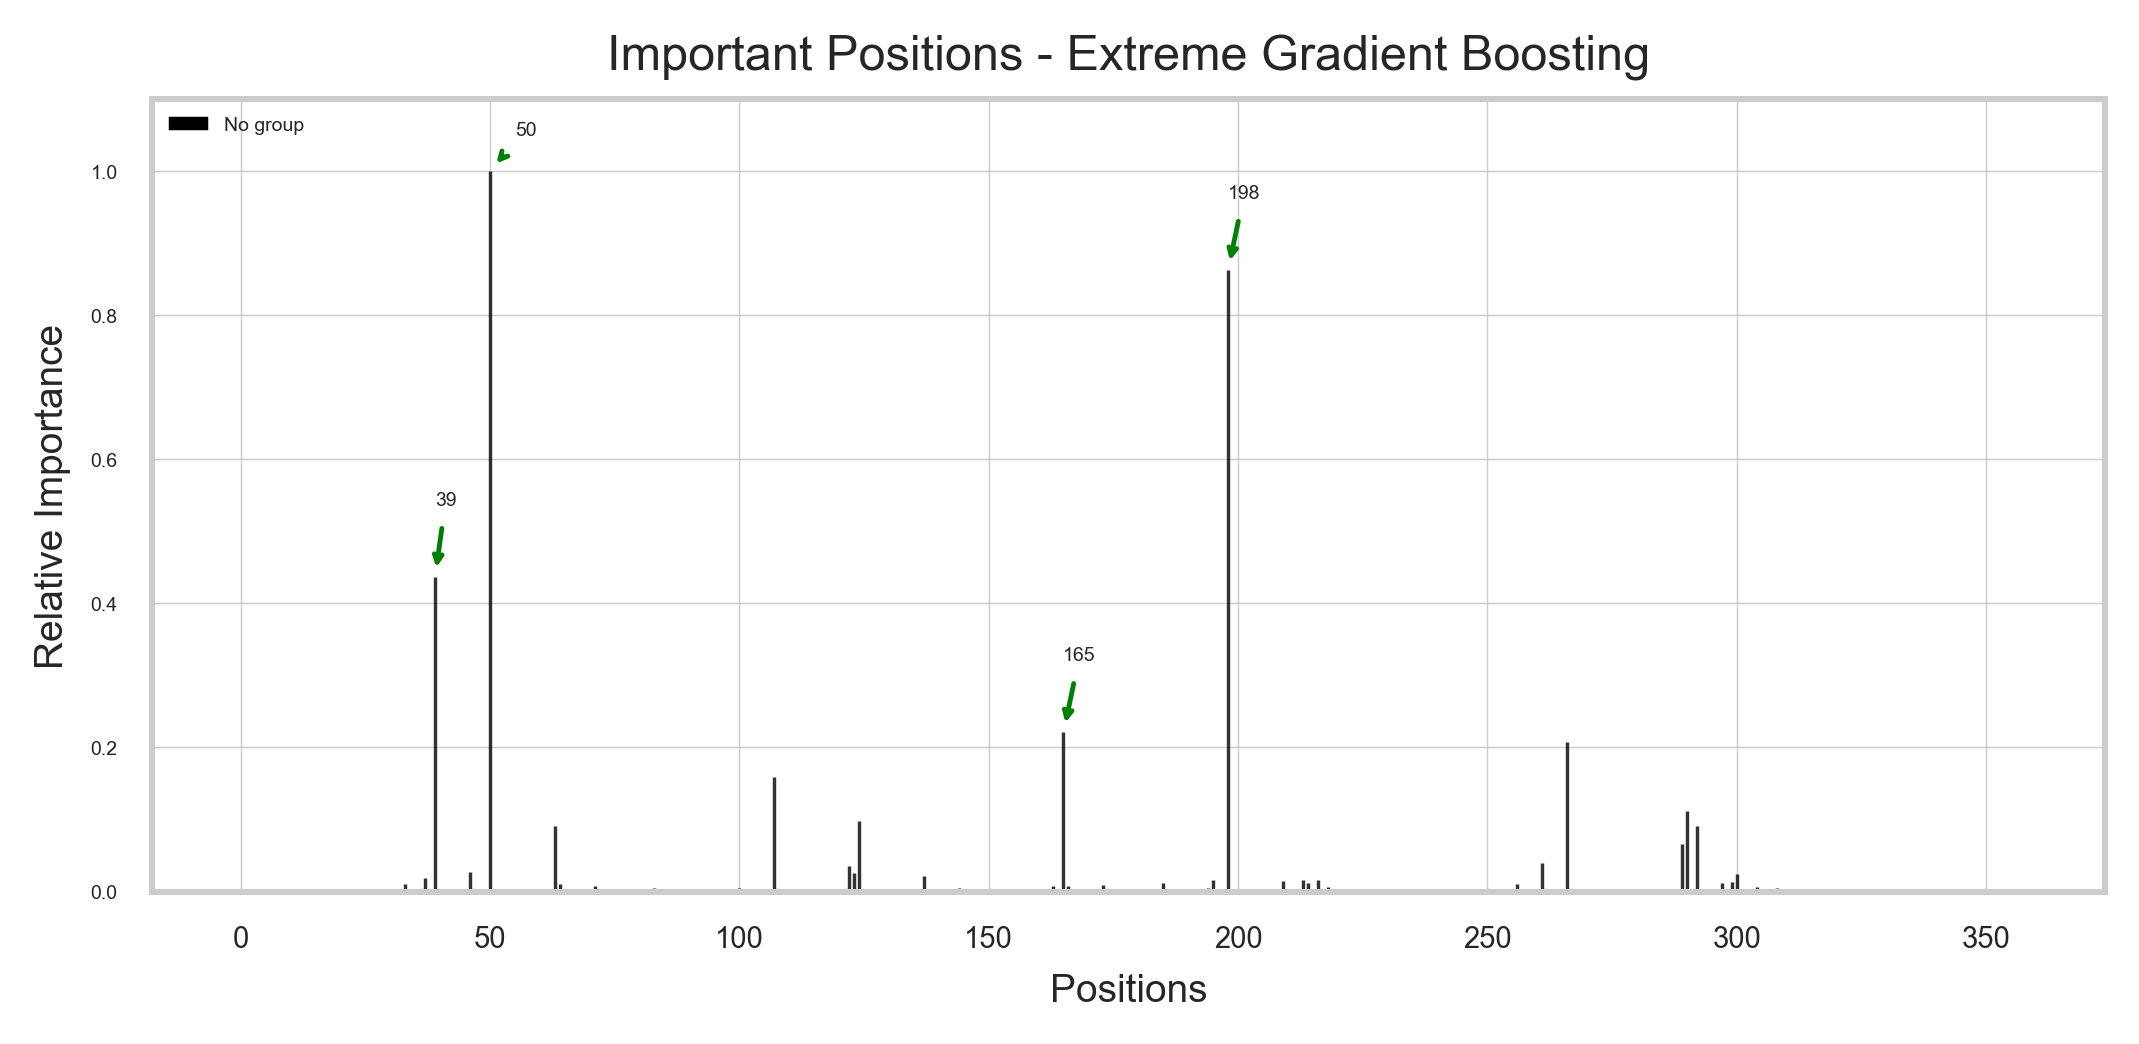

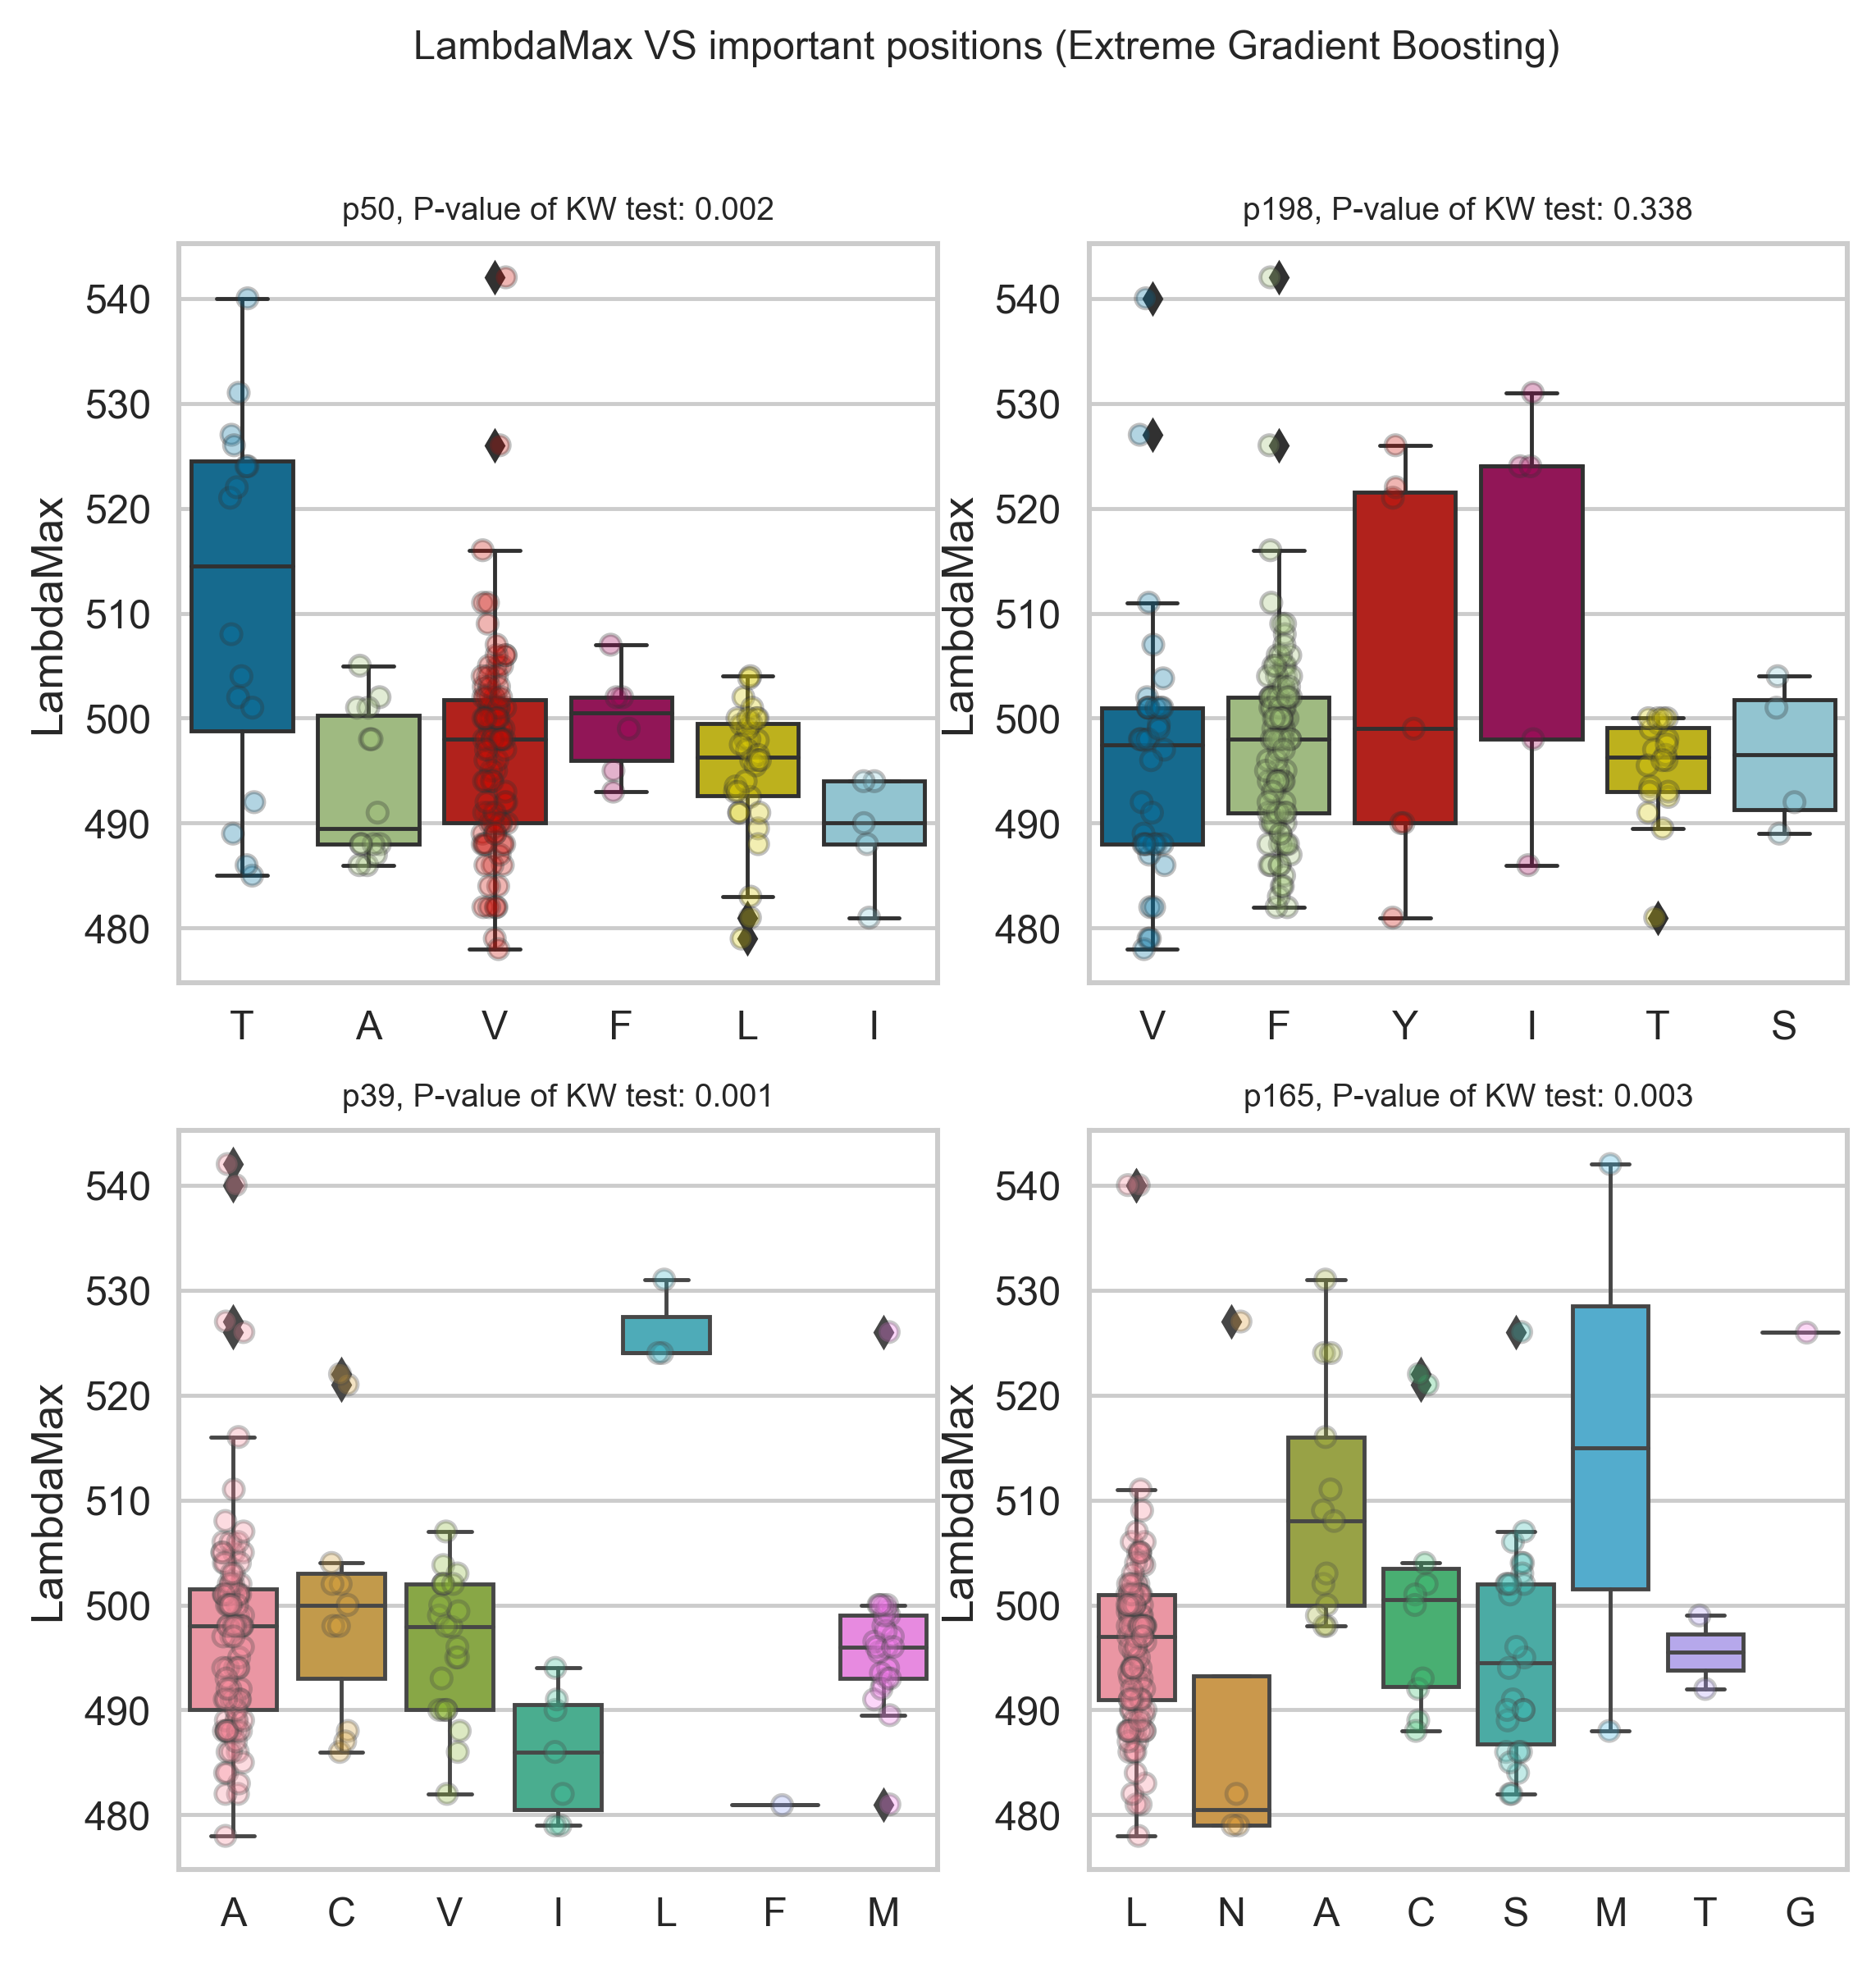

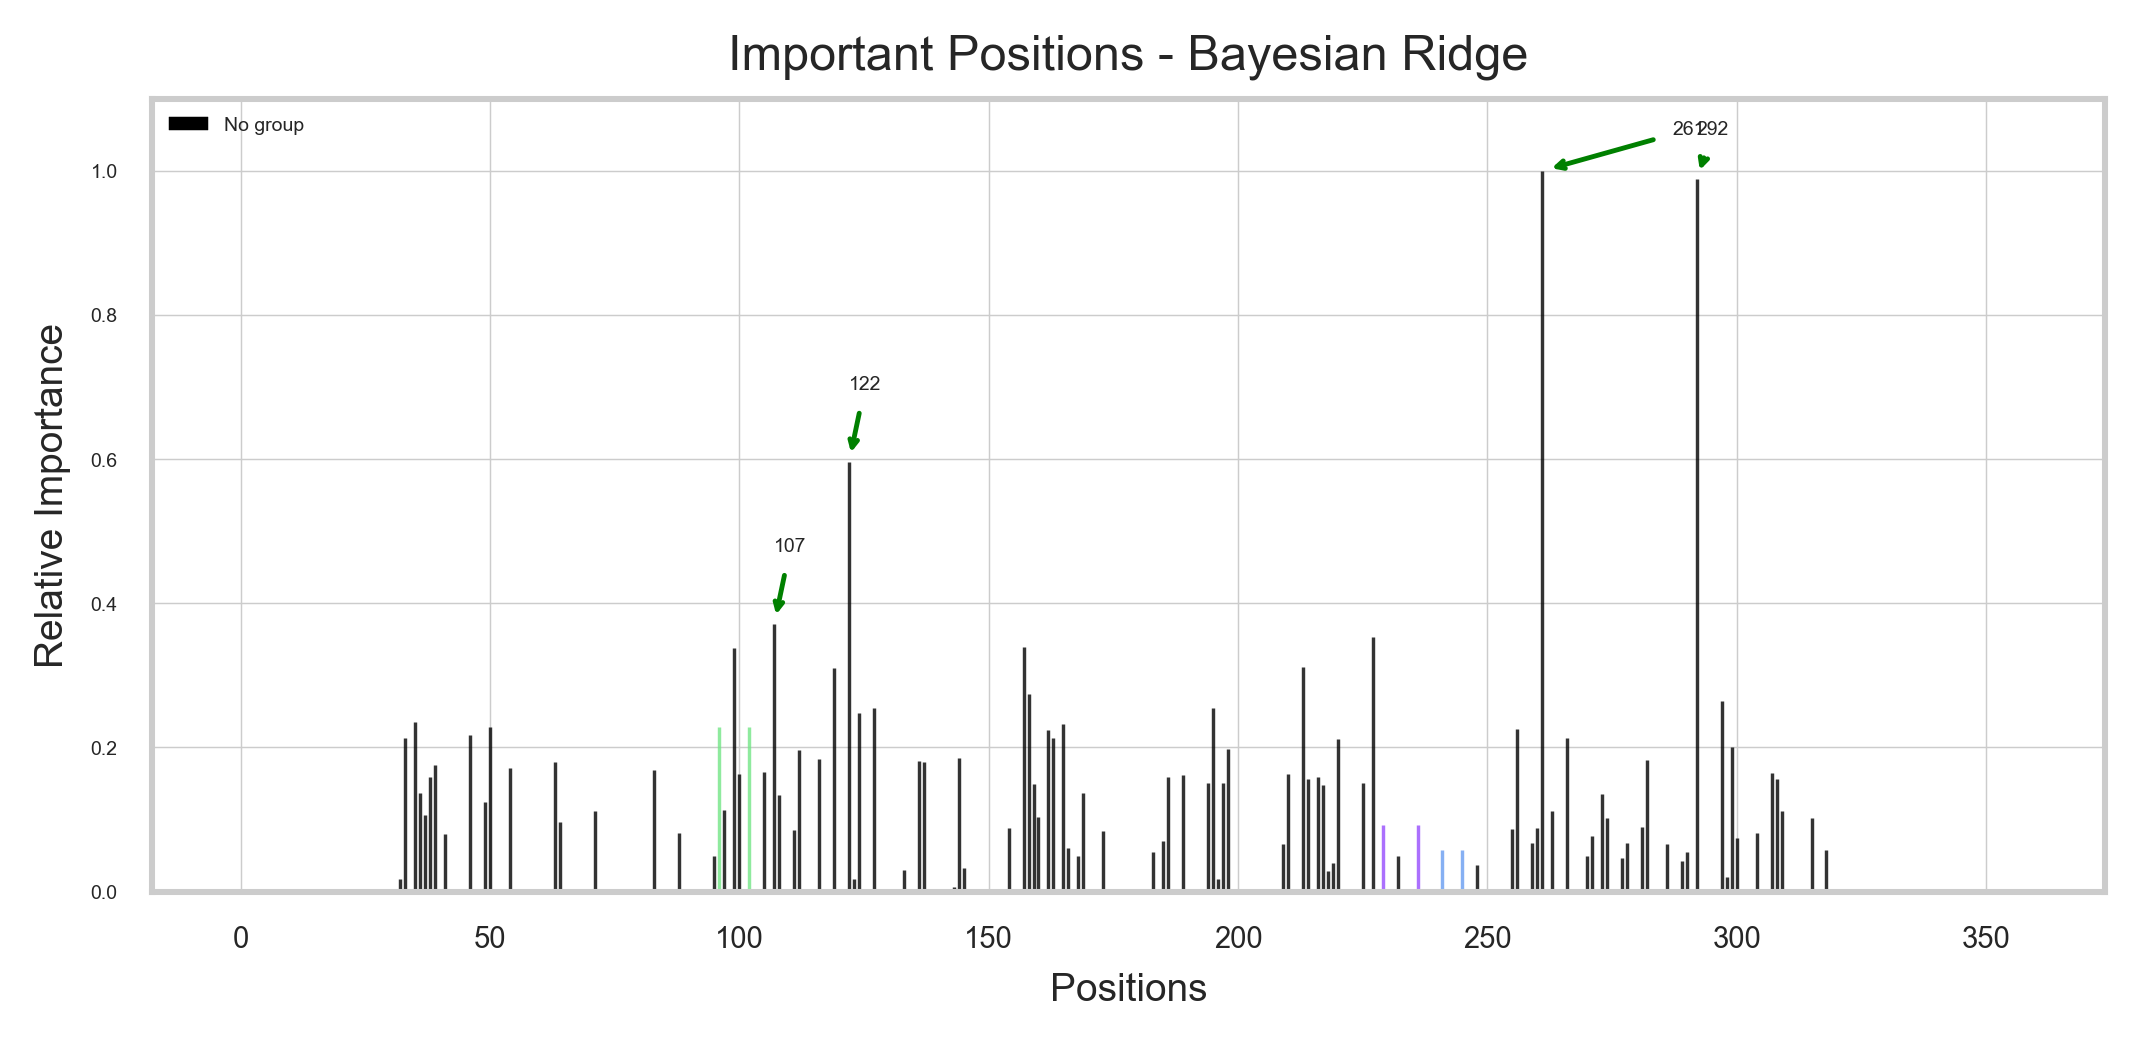

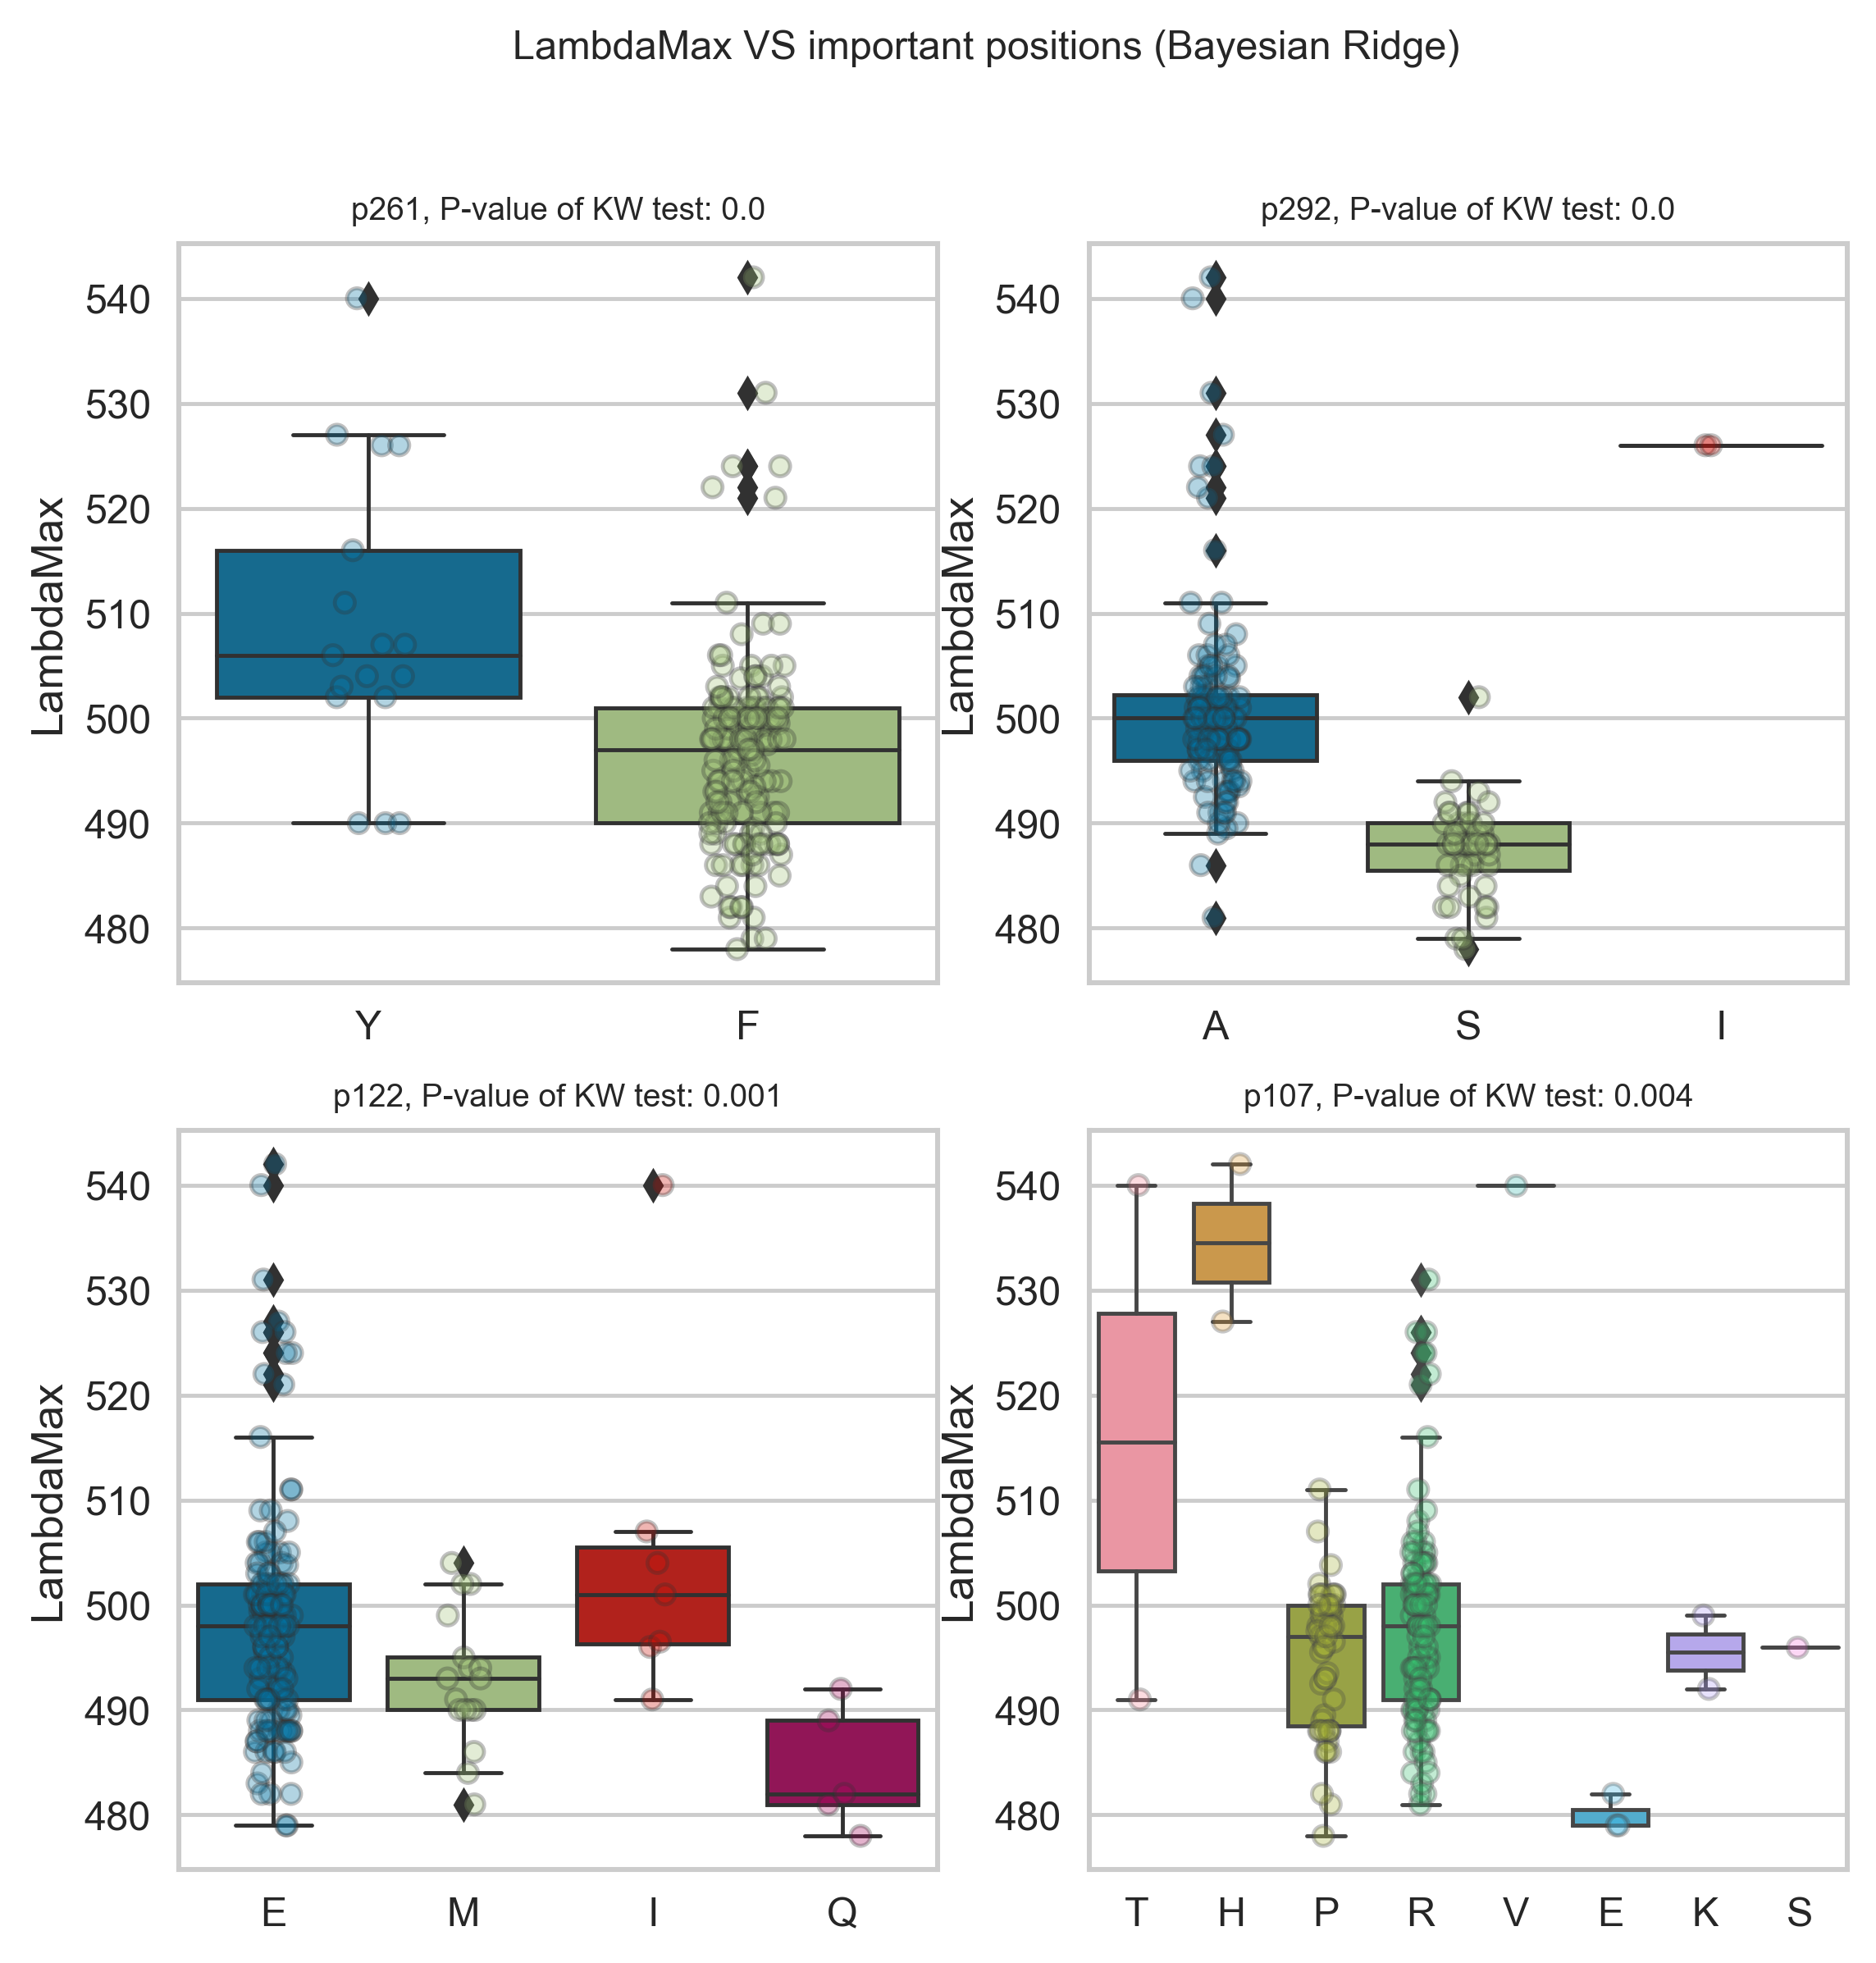

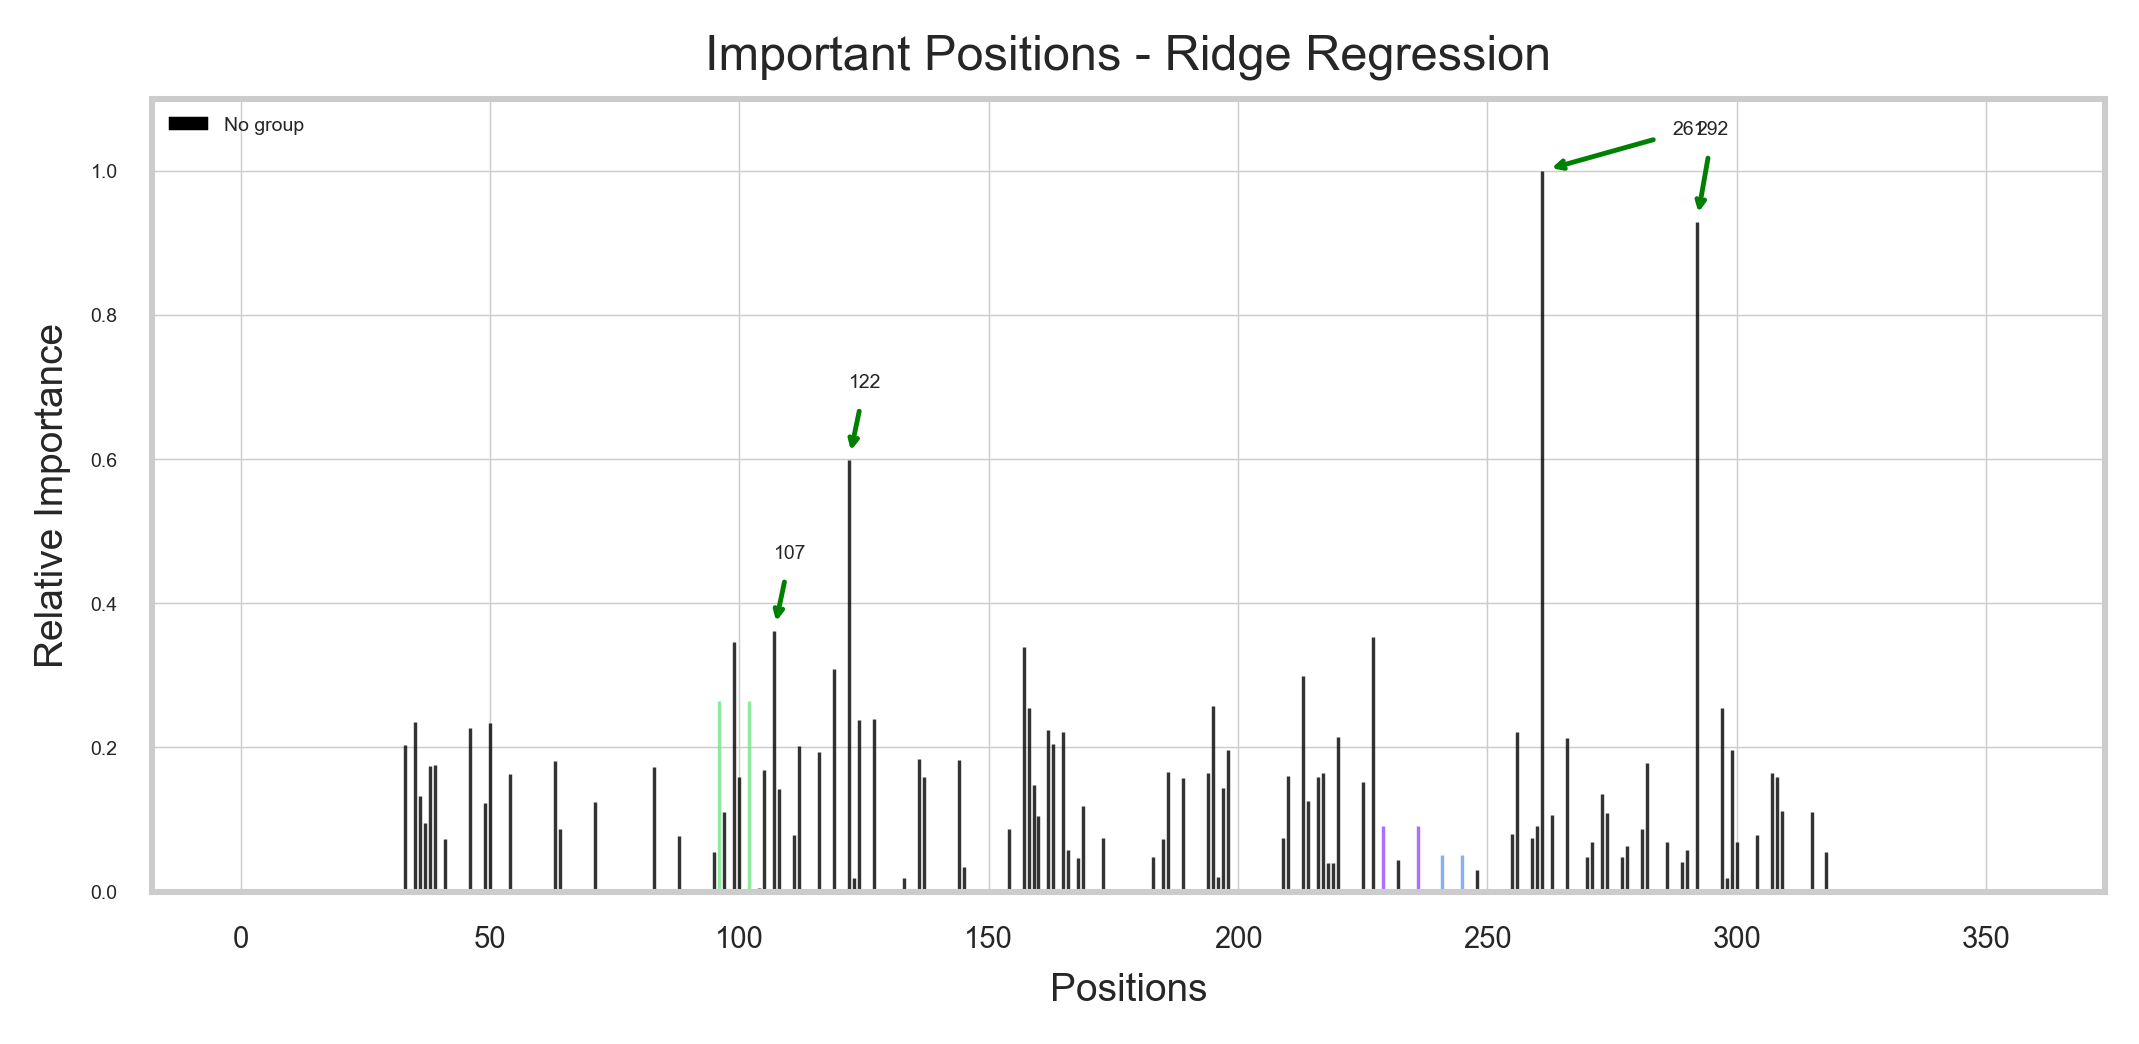

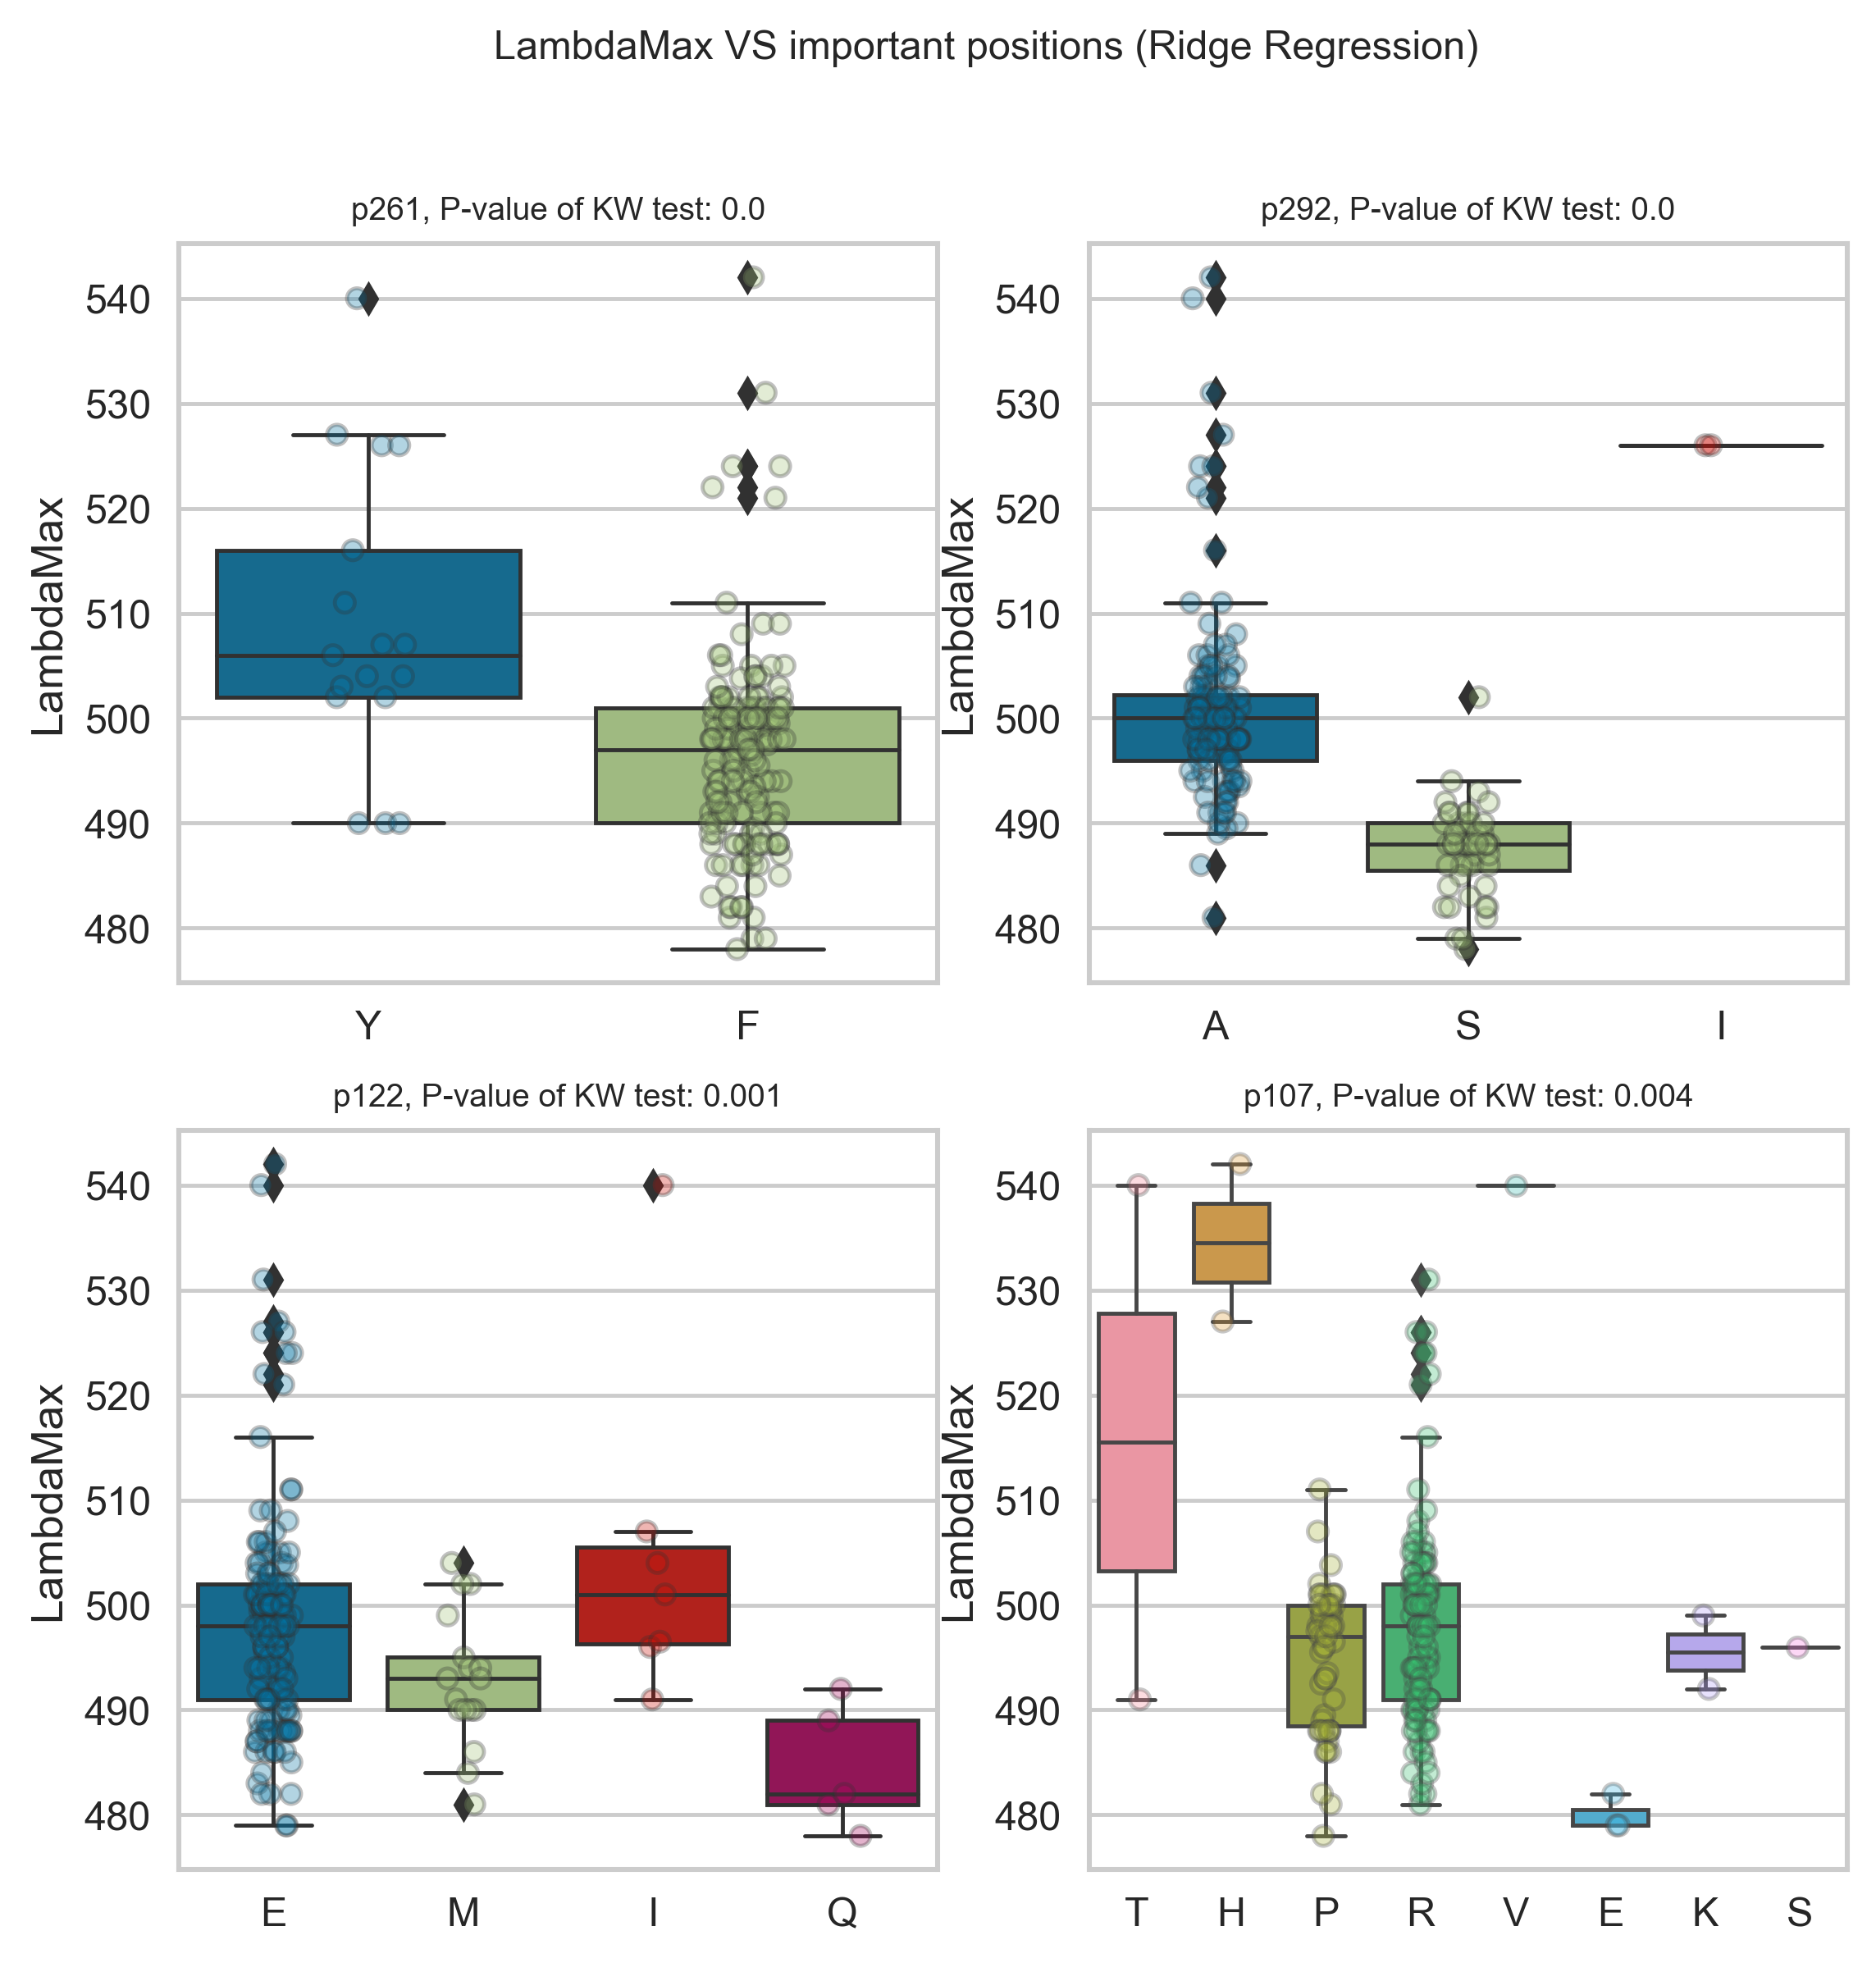

In [22]:
for i in range(3):
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i], 
                  train_cols=train_cols, grouped_features=dc_df,
                  n_positions=df.shape[1],report_dir=report_dir)
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    viz.plot_imp_model(dat =df, trained_model = top_models[i], model_name = model_names[i],
               train_cols= train_cols, grouped_features = dc_df,
                   meta_var = mt, n_positions = df.shape[1], model_type = anaType, report_dir = report_dir)

D:/RahLab/deepBreaks/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-04-29_14-44-06/mean_350.png


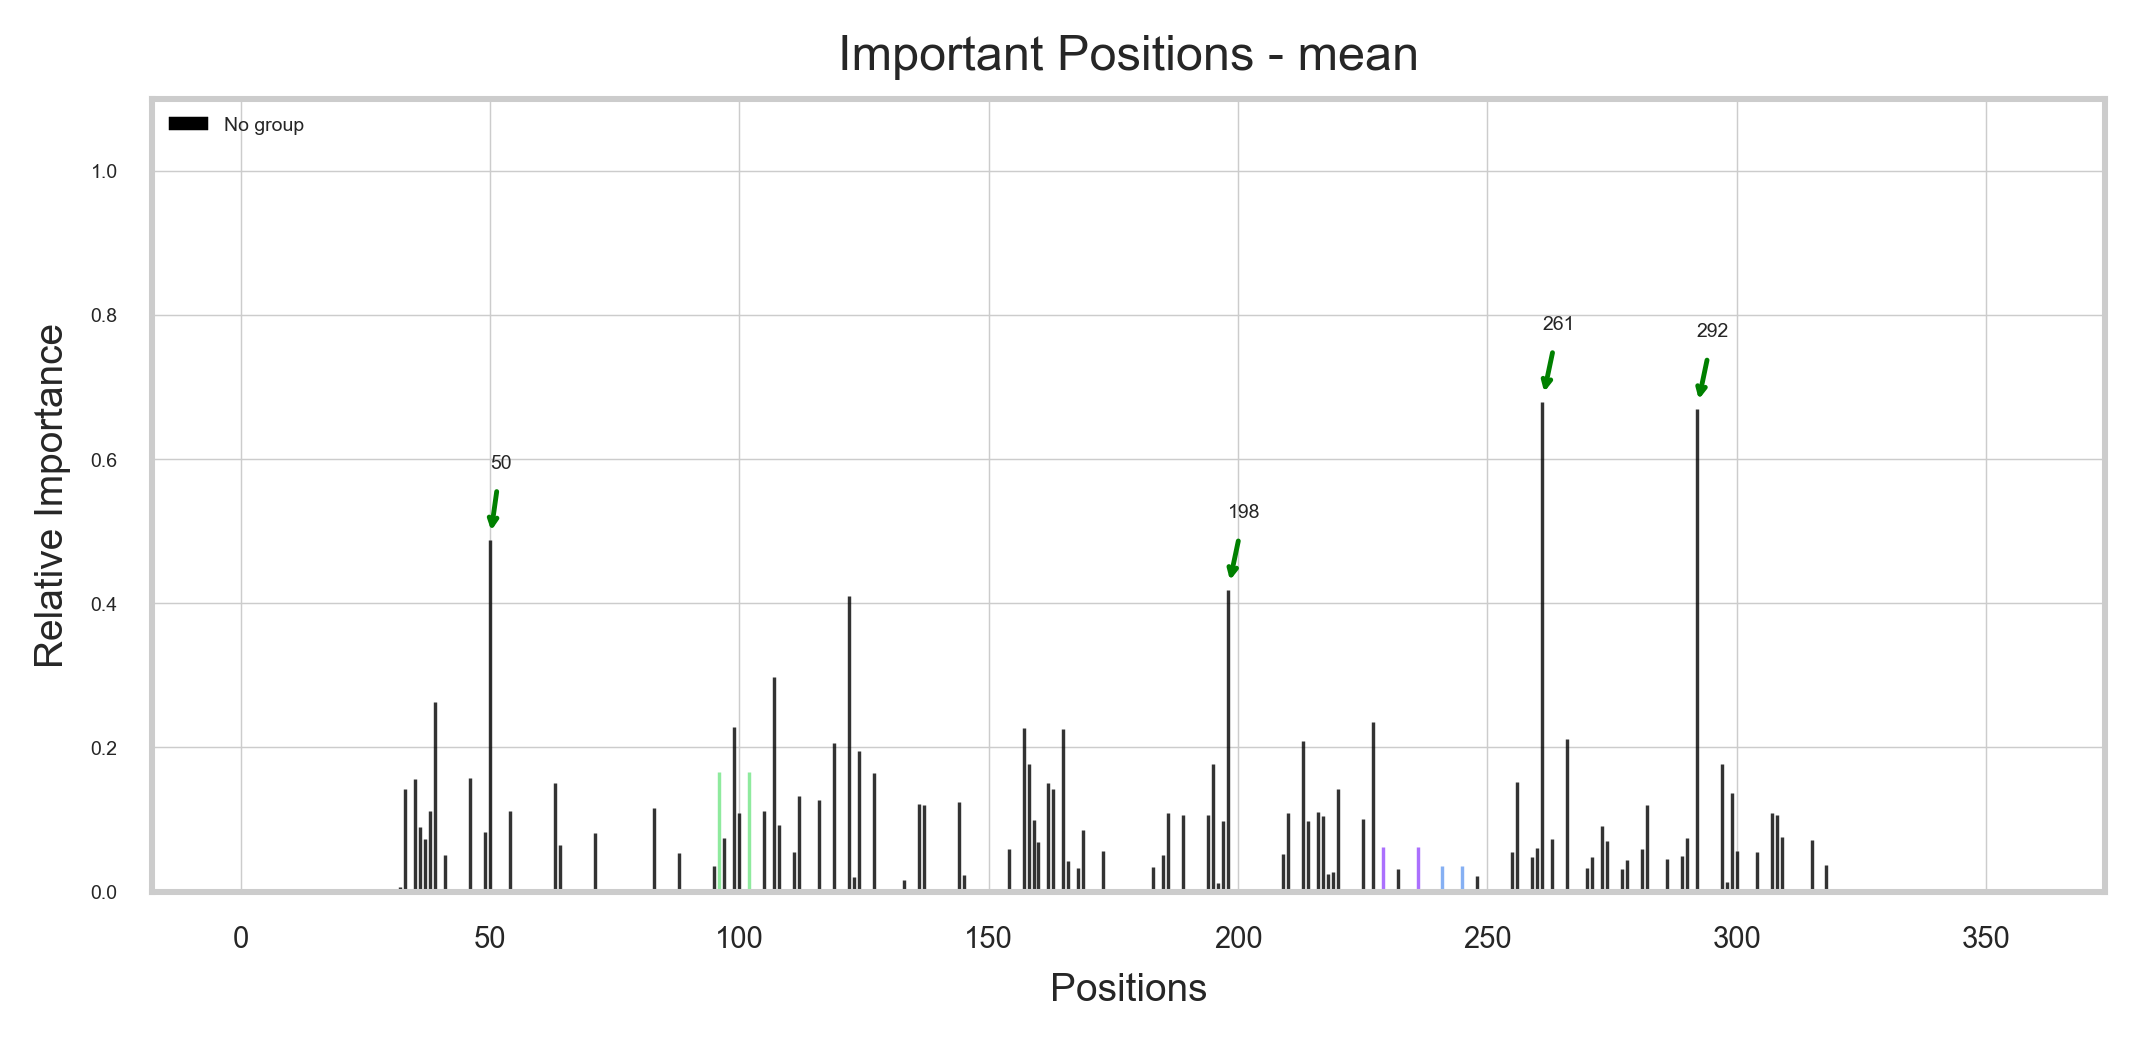

In [23]:
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, train_cols=train_cols,grouped_features=dc_df,
                  n_positions=df.shape[1],report_dir=report_dir)
viz.dp_plot(dat = mean_imp, model_name= 'mean',imp_col='mean_imp', report_dir=report_dir)

Model  0  Done
Model  1  Done
Model  2  Done


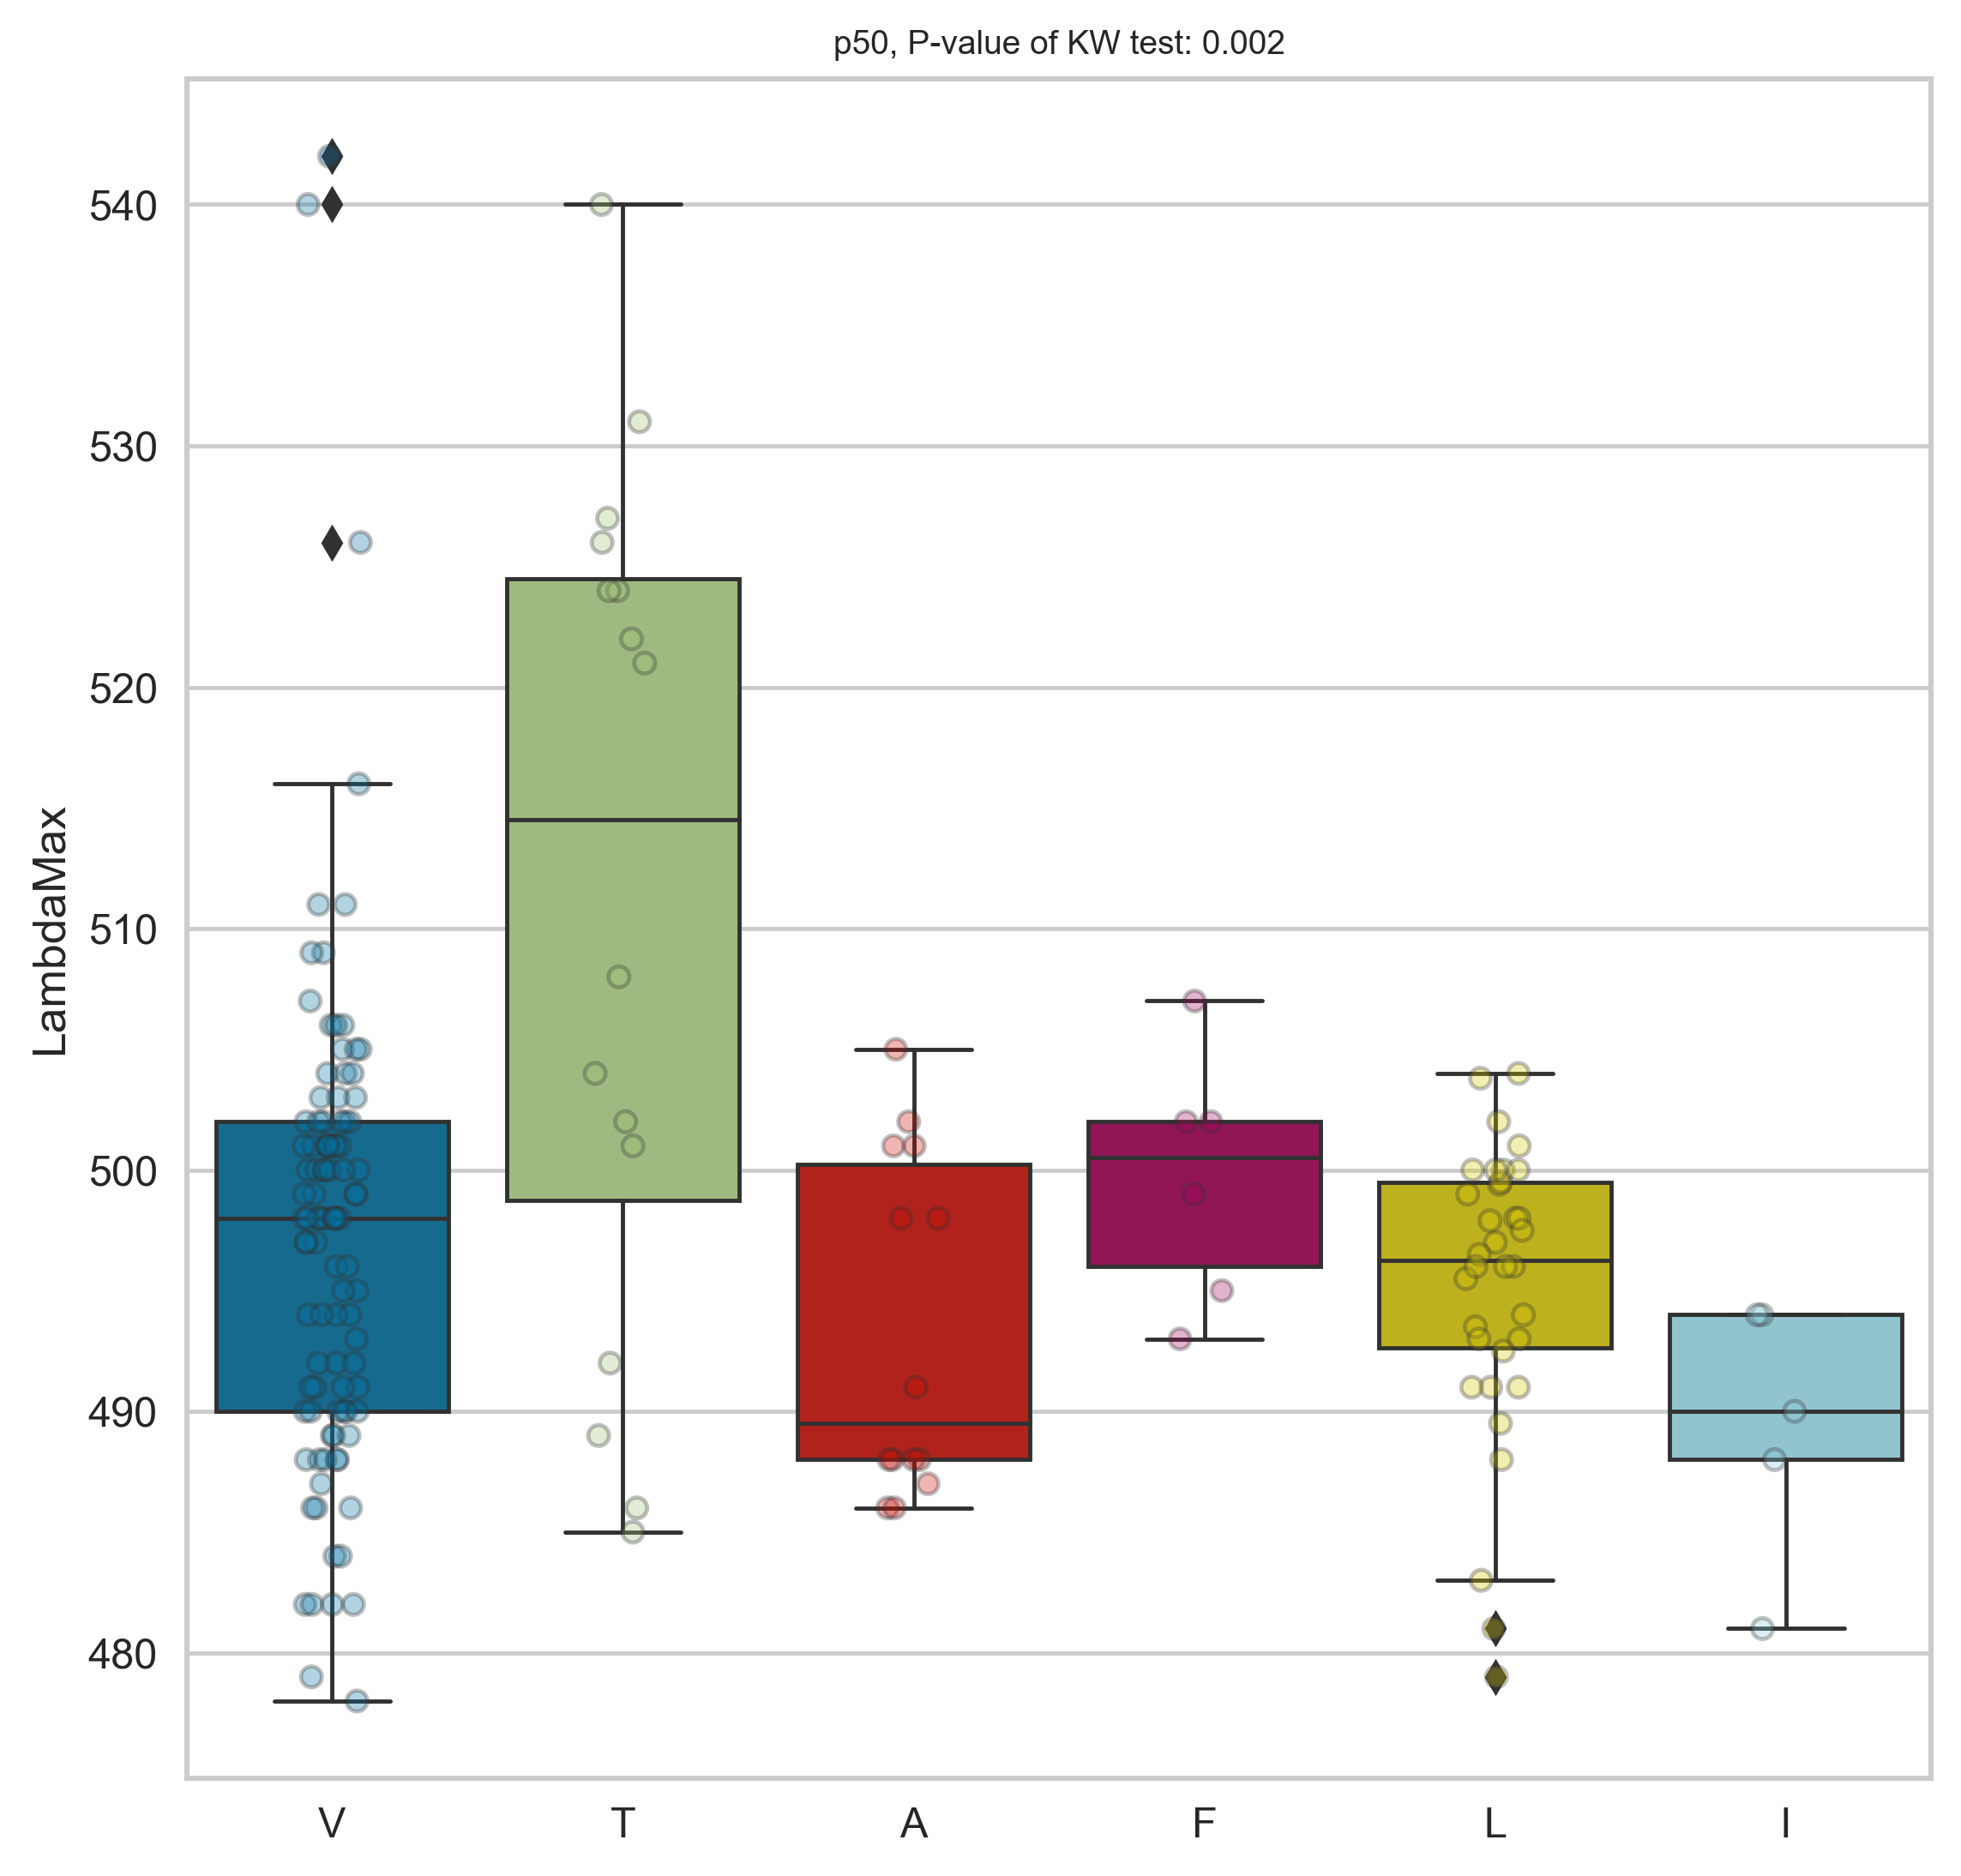

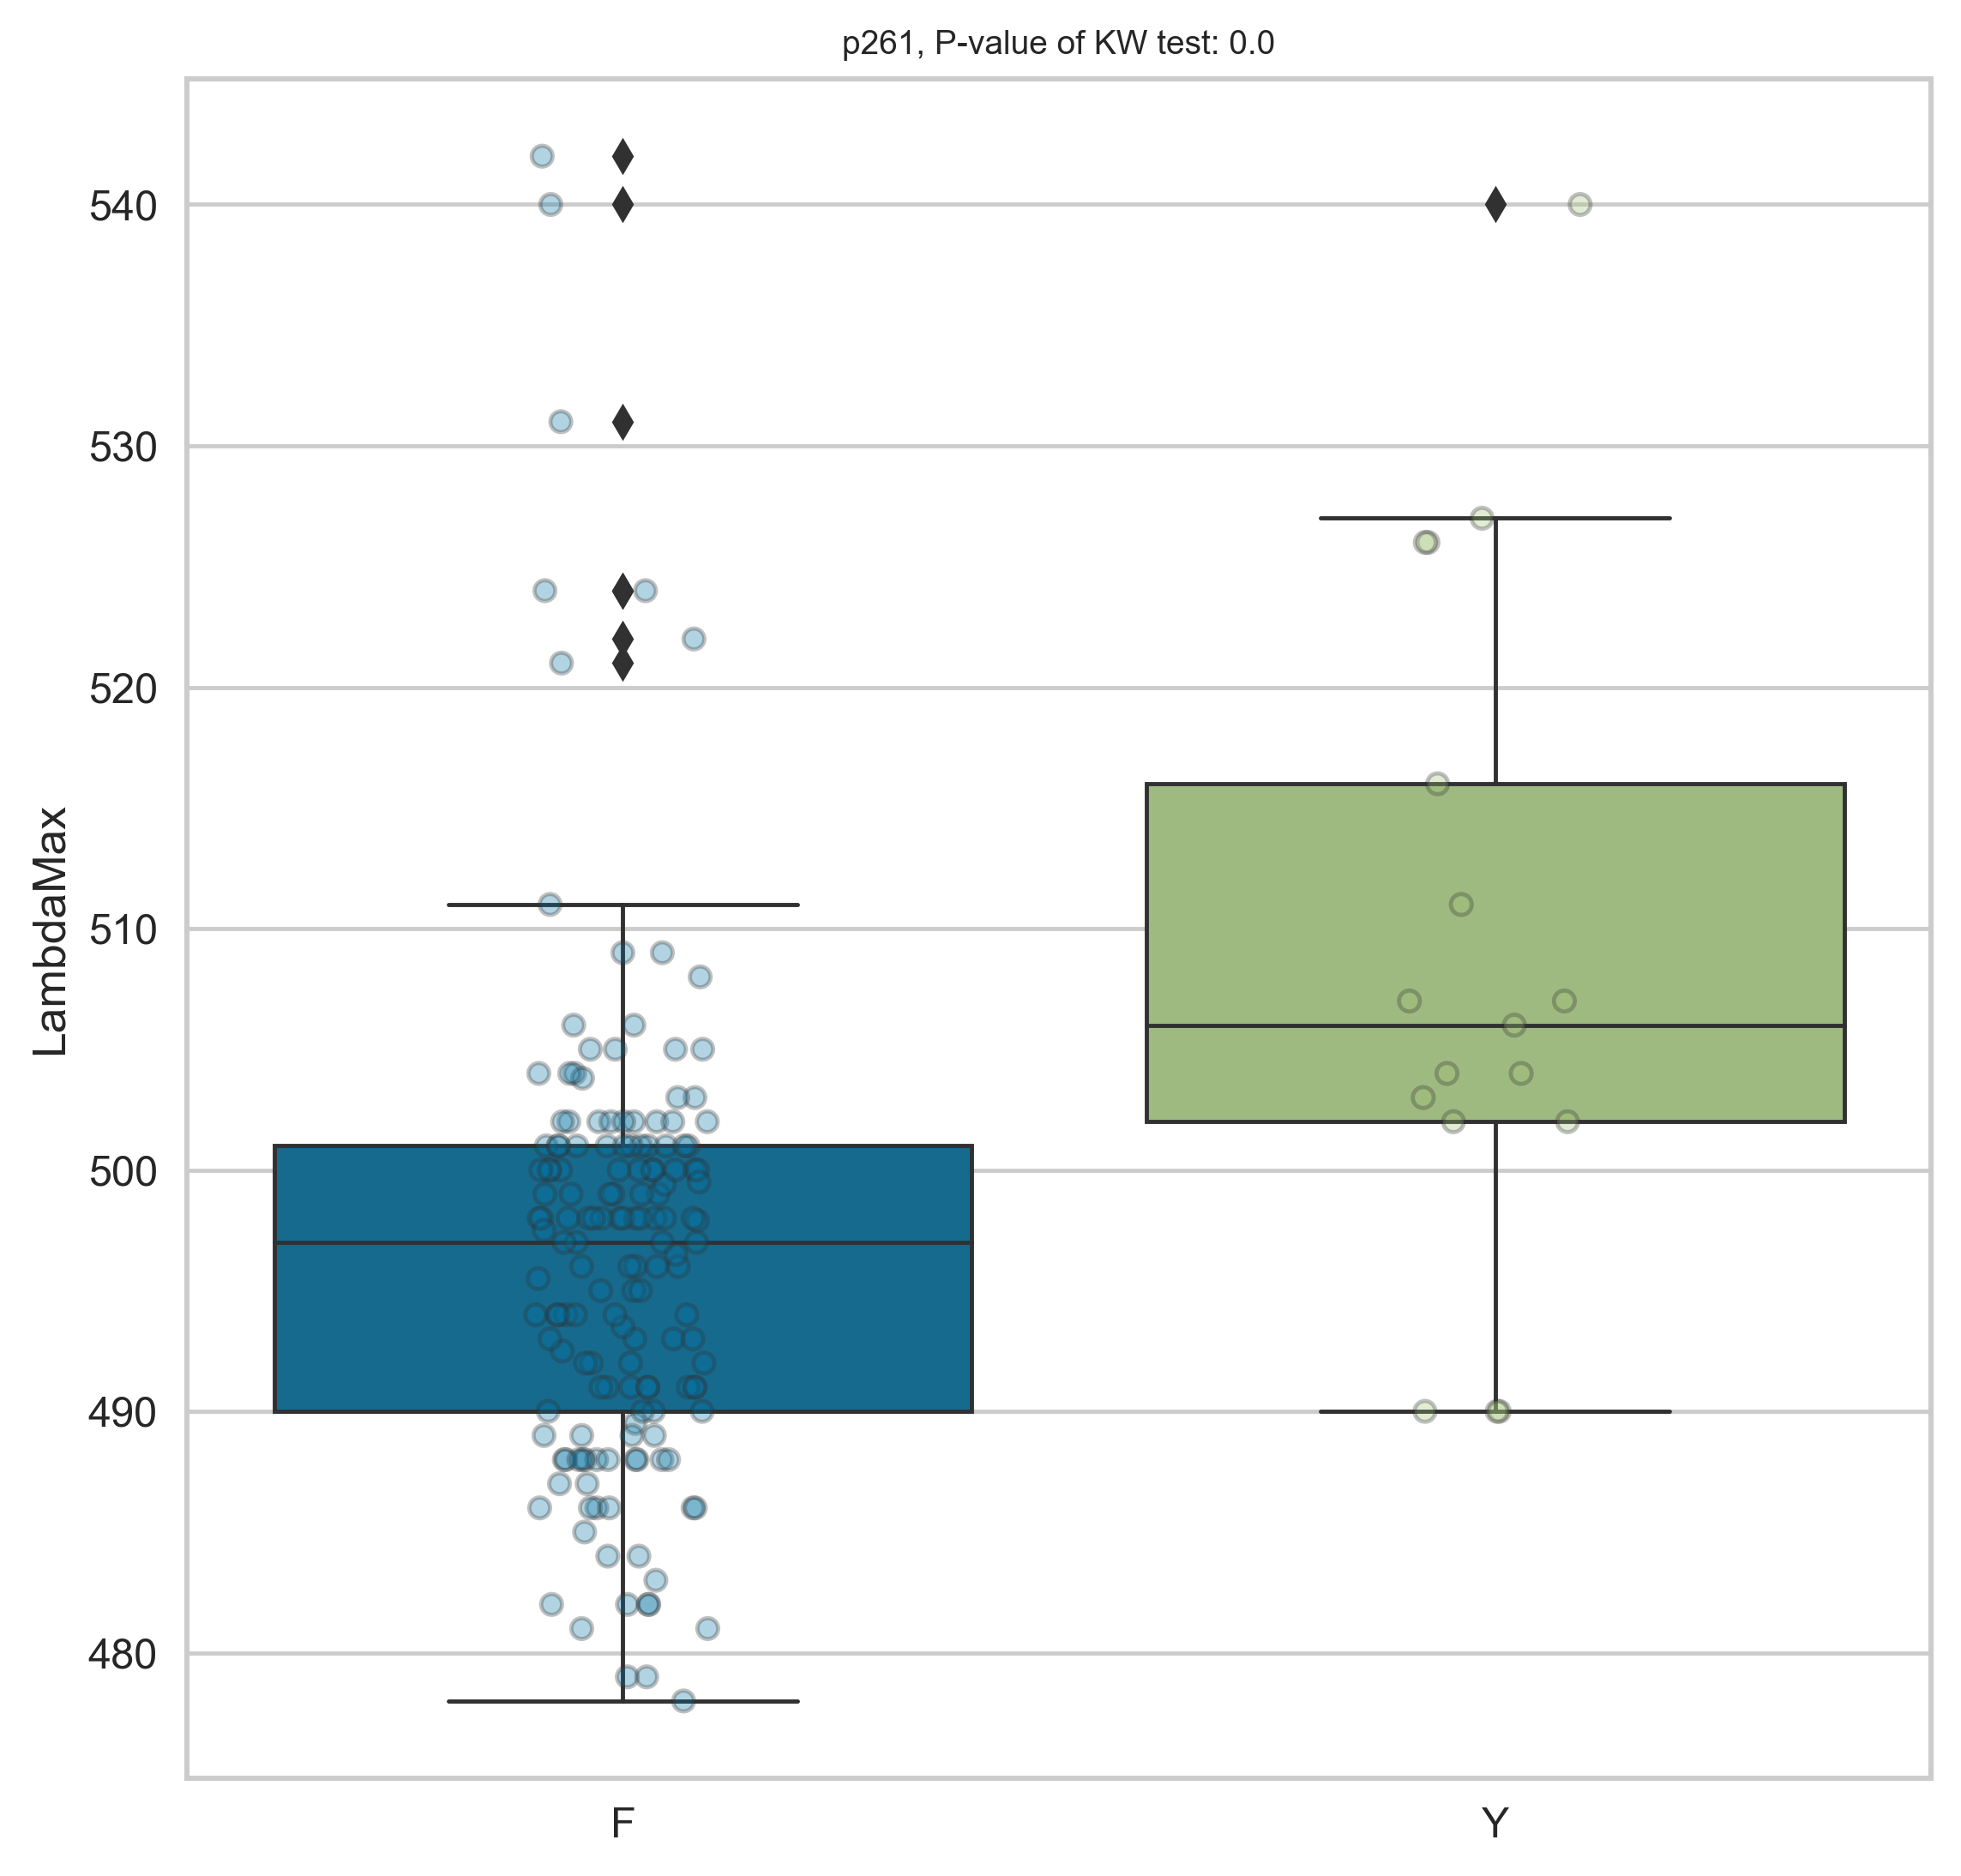

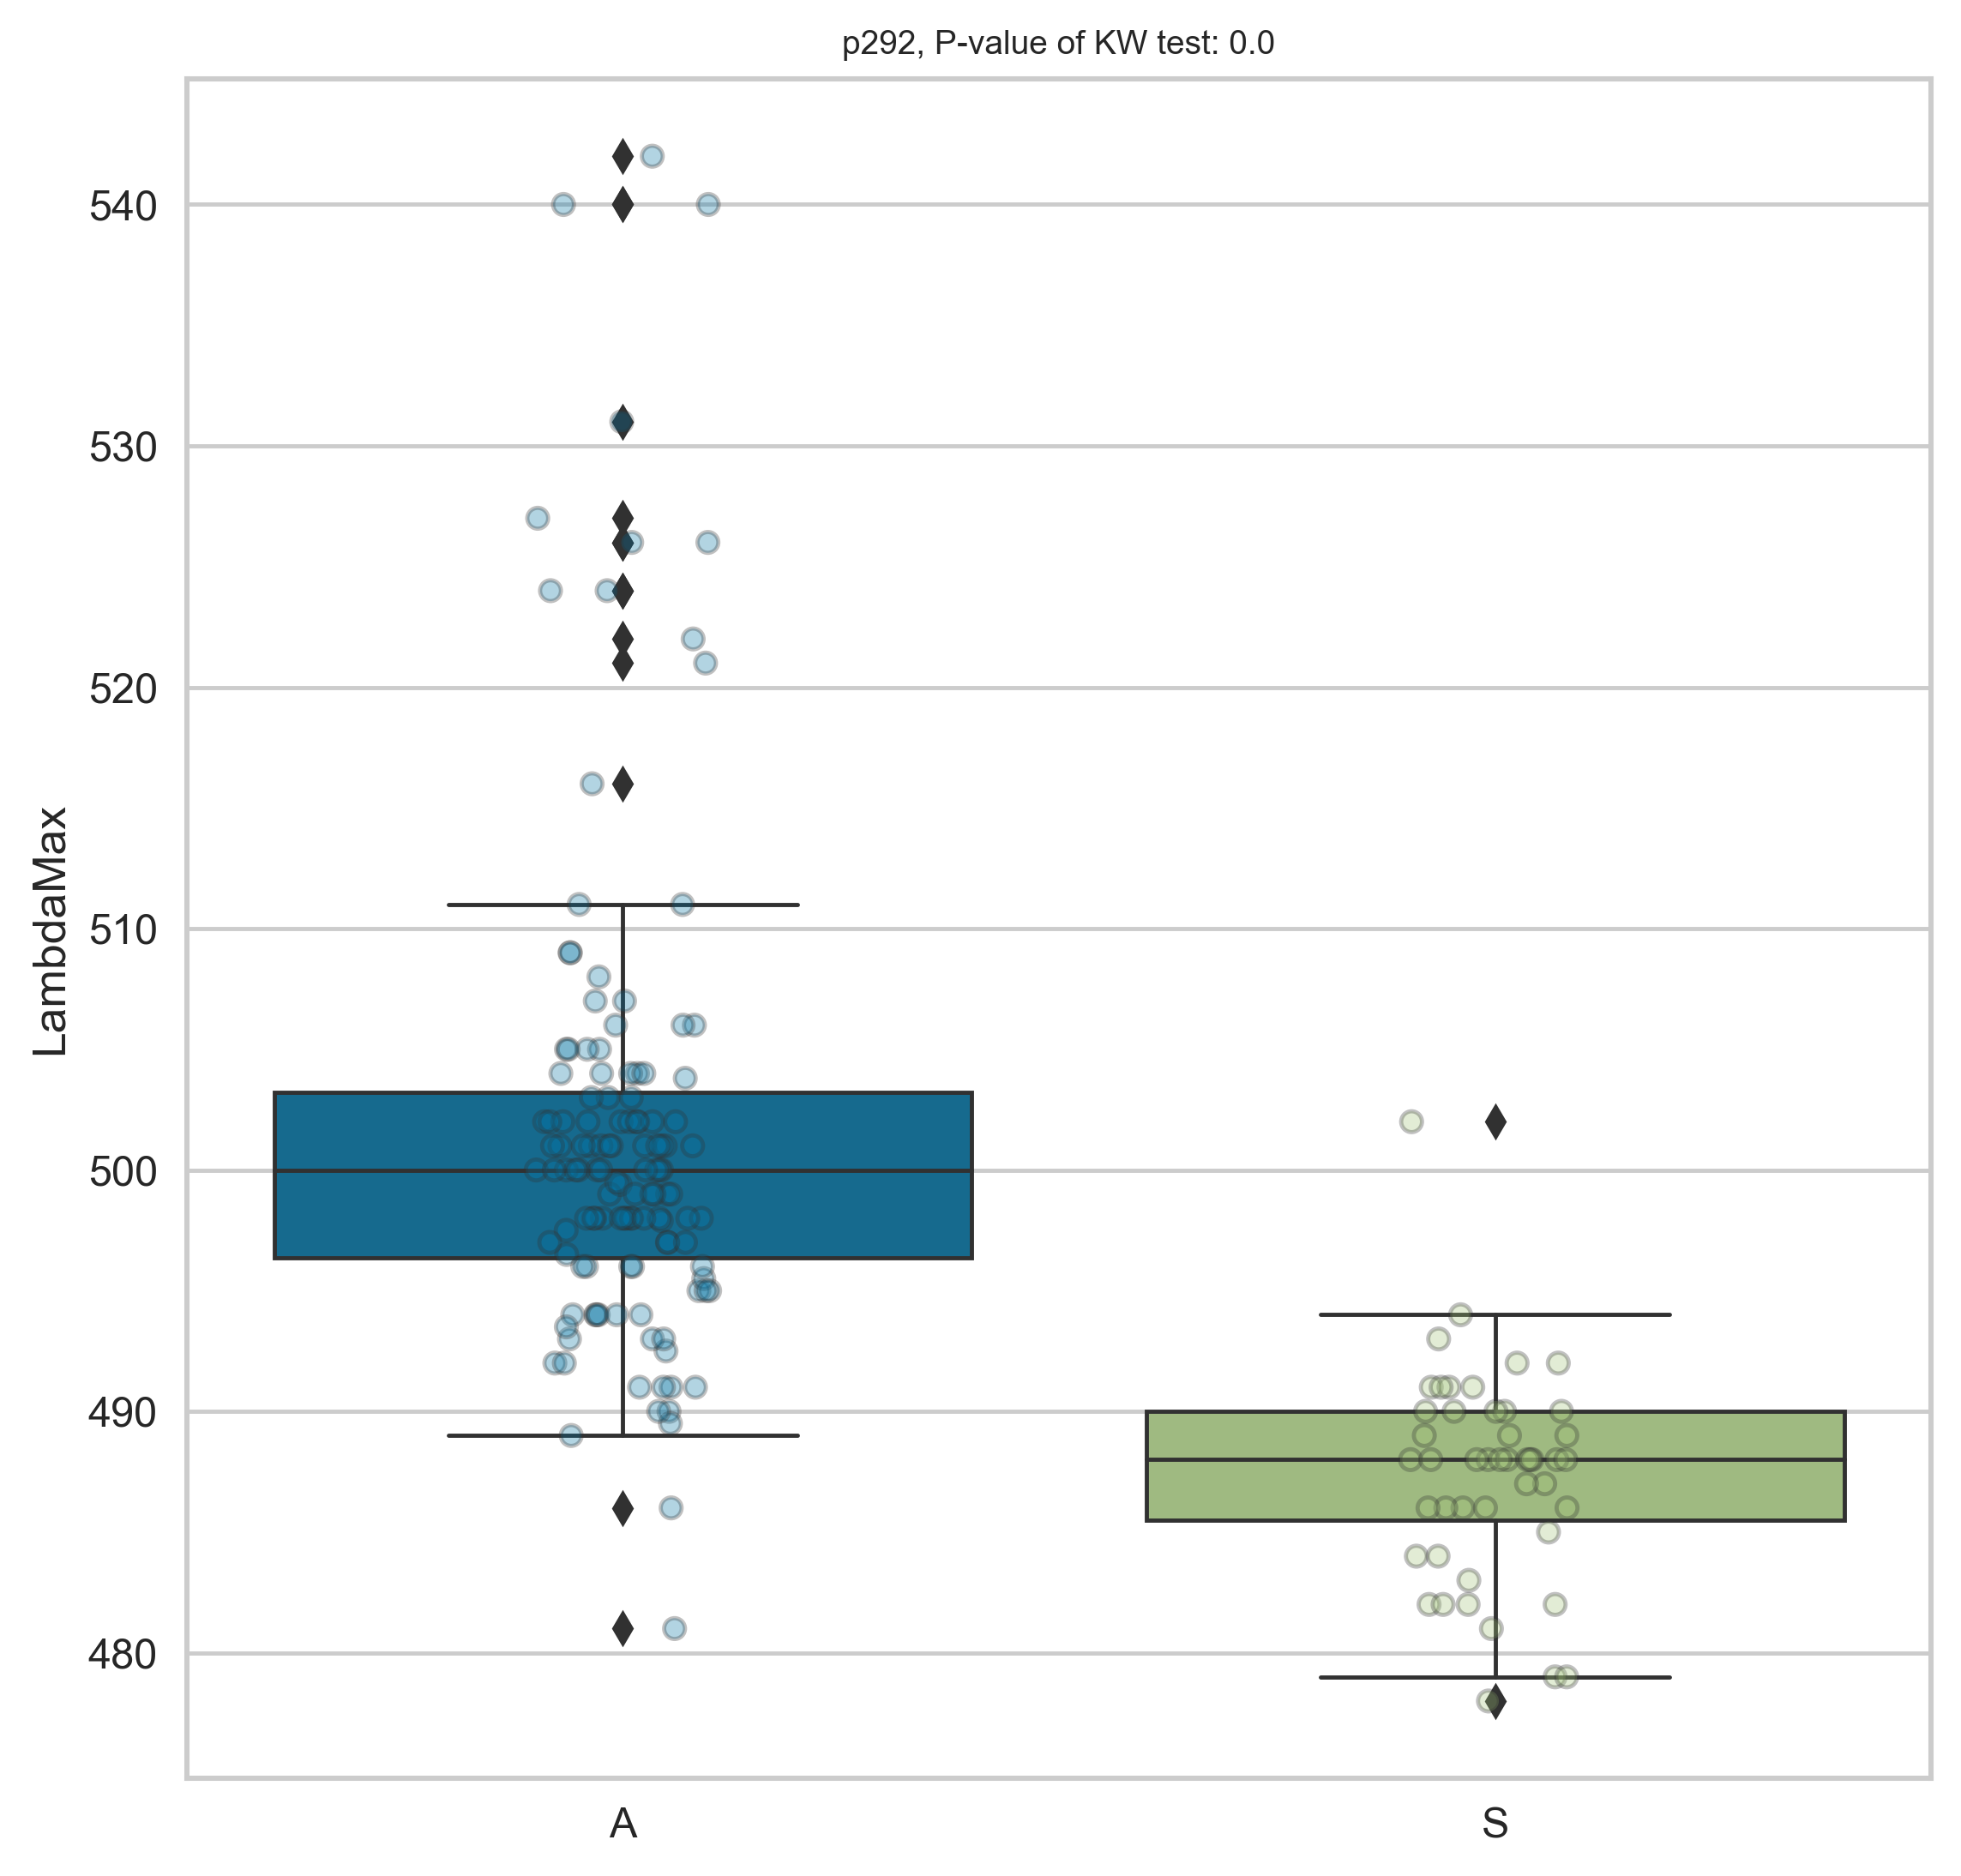

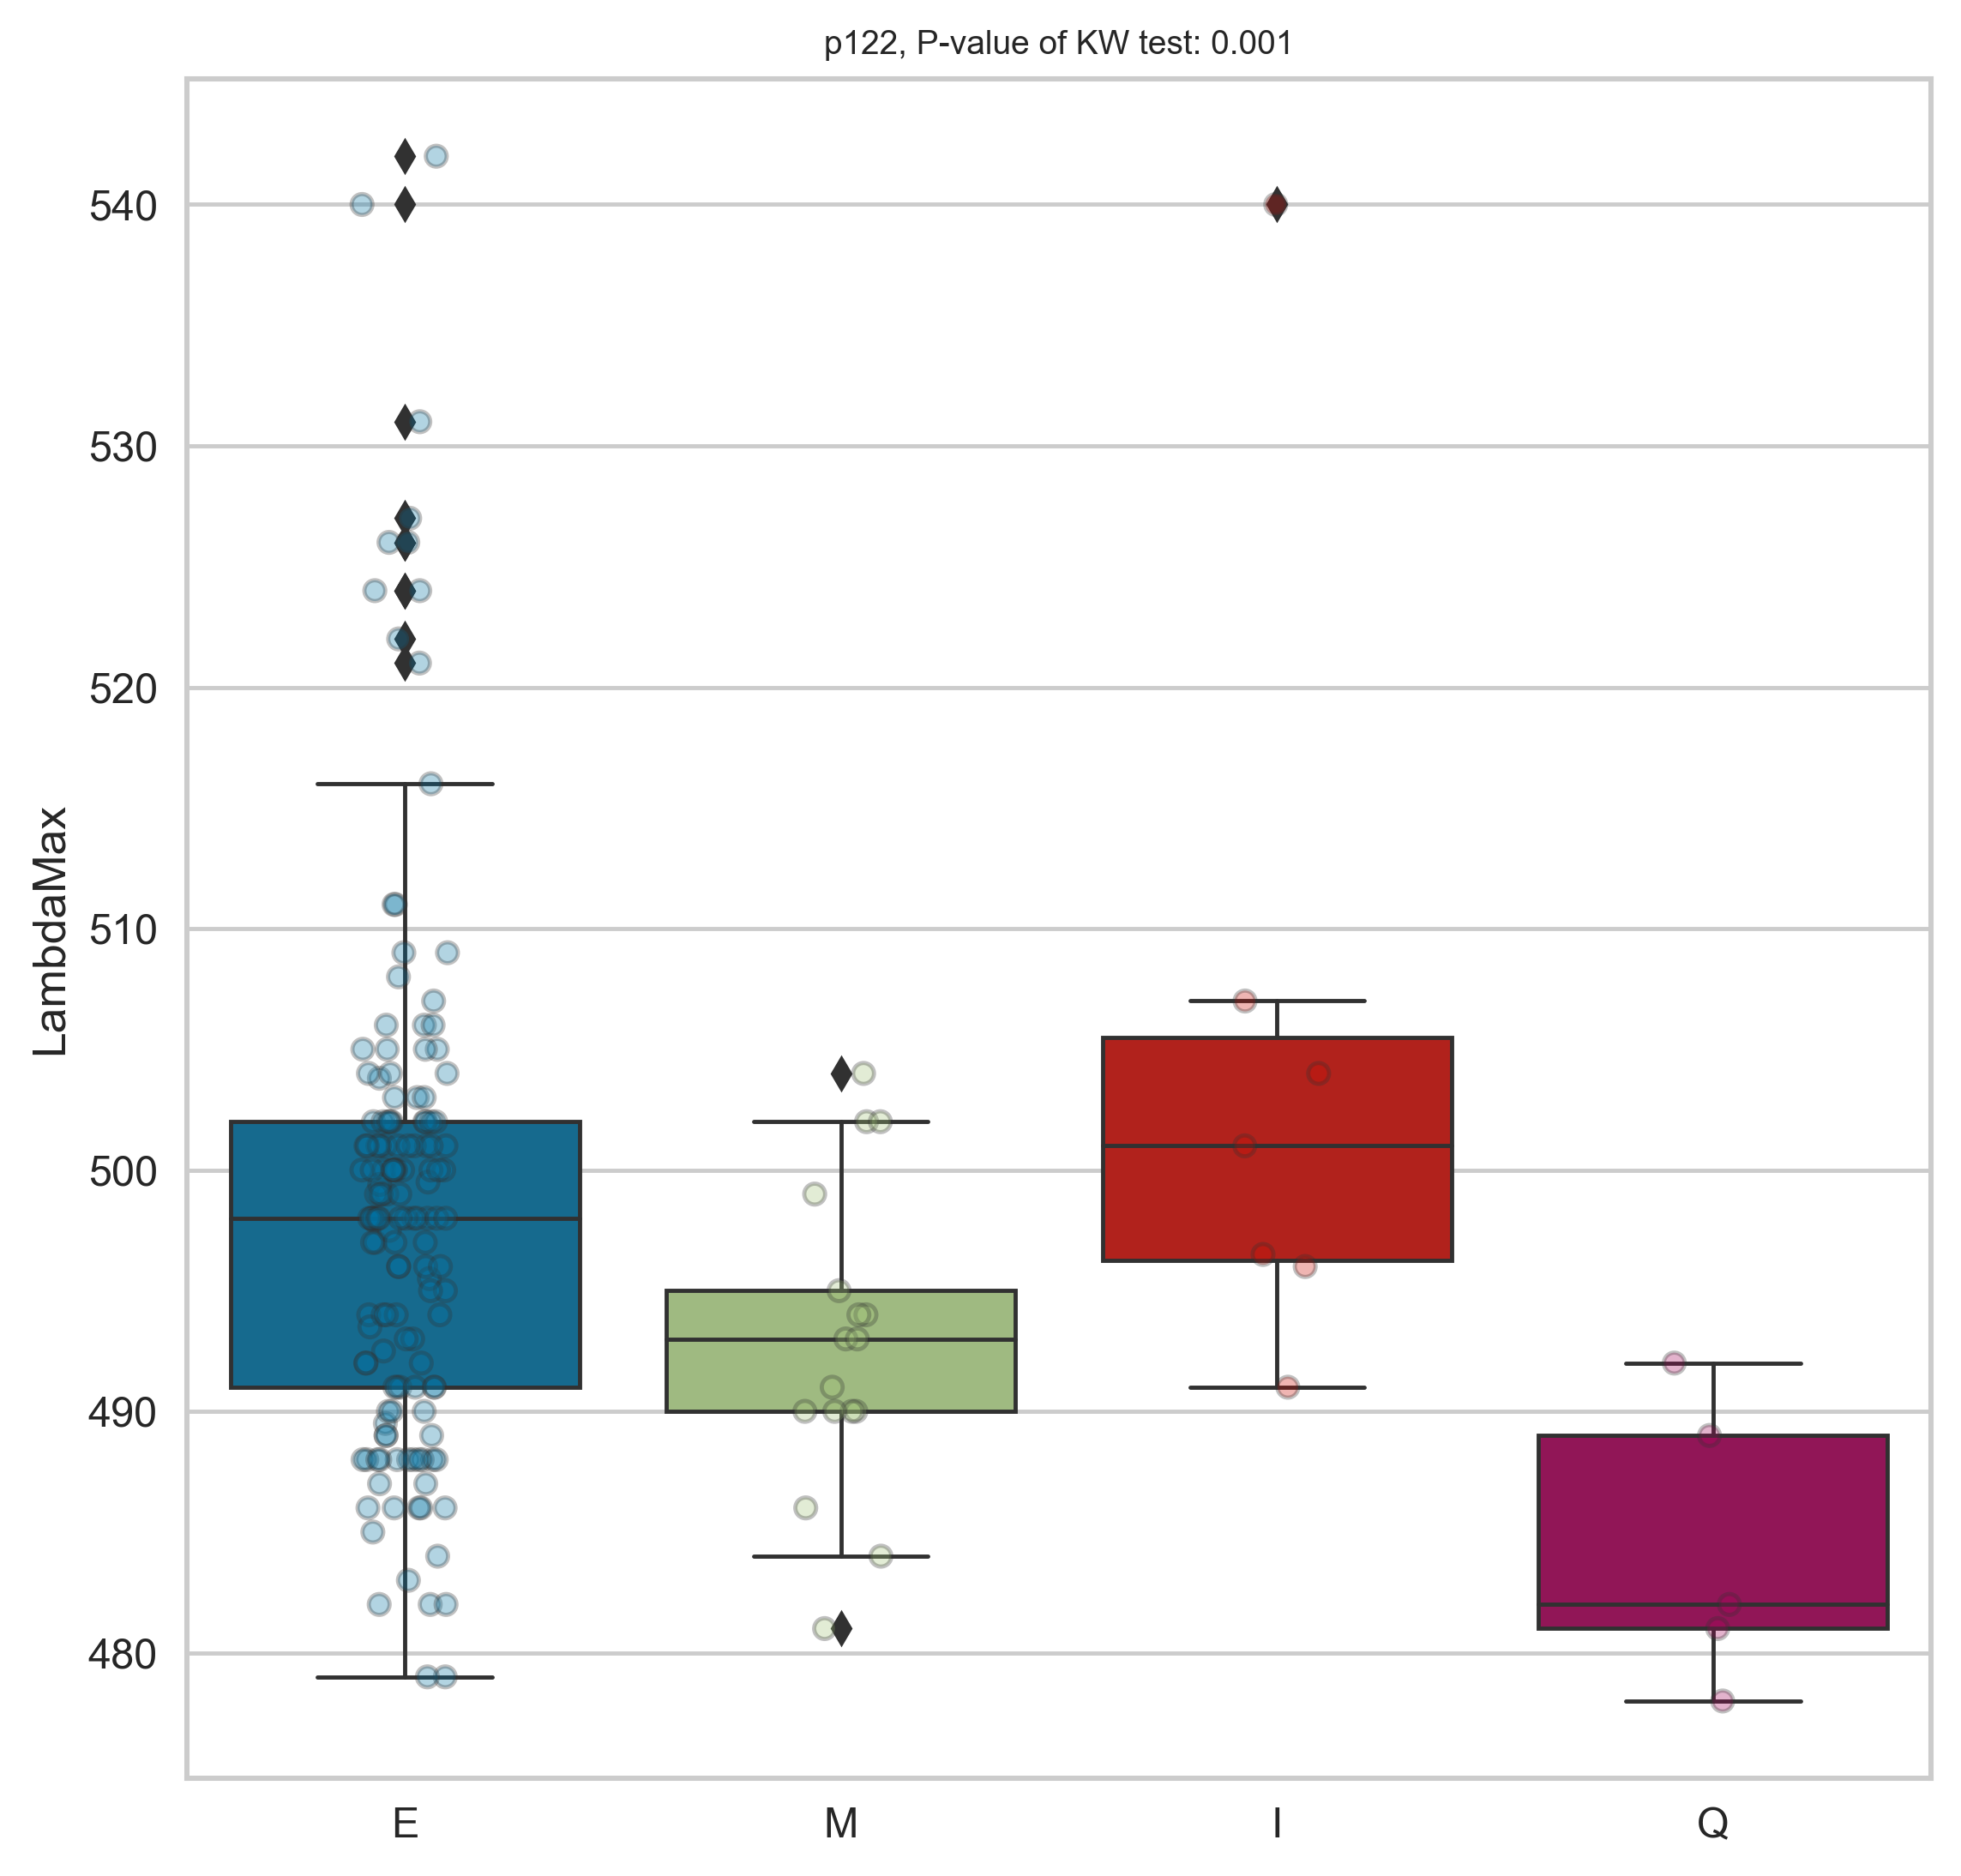

In [24]:
viz.plot_imp_all(trained_models=top_models, dat=df_cleaned, train_cols=train_cols,
             grouped_features=dc_df, meta_var = mt, model_type = anaType,
             n_positions= df.shape[1], report_dir = report_dir)